---
title: Titanic - Machine Learning from Disaster
subtitle: Assignment 1 submission
authors:
  - name: Michael Berger
    email: vo1kod4v@gmail.com
date: 2024/02/20
myst:
  enable_extensions: ["deflist","myst-parser"]
exports:
  - format: docx
  - format: pdf
    template: arxiv_nips
---


In [ ]:
#    template: plain_latex_book
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'titanic:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F3136%2F26502%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240427%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240427T185713Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7d5e8fb644f88bb3c1216b99279e5d7b03fdf539c154d3b1bb63bca36941876c5943680cad6834046d3aca8bdf90a32f25d8e90abf44ecdee97f198dca66f58cea19558f6047bd39c10d52b5b8a0d129860f50f1dbf01be349f354894b0fa1b990c5eefe13c64bb89736e535fb4b576a52a03b3c54e52600602e32e99c06046817e9033b88d243372ce7d73d5bcdc3959a95ac635f0605b7fd819bdc32abca86457c5134bfa03b9d8c19d85cdf95d55ad23dfea13c6c3a7cd1698b3c974e8d974190771ce8e7361b7ff82362c2c5531ab1872df3feb7a8c4e698103240f3435816898262816d665ddd64fc05c4692c9a3e87eadaf8250dadd42c2e9fc8eb1d5b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')



[==================================================] 34877 bytes downloaded
Downloaded and uncompressed: titanic
Data source import complete.


In [ ]:
!pip install pandasql
#!pip install matplotlib==3.7.0

# Titanic - Machine Learning from Disaster





## Overview

The data has been split into two groups:

- training set (train.csv)
- test set (test.csv)

The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

We also include gender_submission.csv, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.

**Data Dictionary**

|Variable|	Definition|	Key|
|----:|:------------:|:------|
|survival|	Survival|	0 = No, 1 = Yes|
|pclass|	Ticket class|	1 = 1st, 2 = 2nd, 3 = 3rd|
|sex|	Sex	|
|Age|	Age in years	|
|sibsp|	# of siblings / spouses aboard the Titanic|
|parch|	# of parents / children aboard the Titanic|
|ticket|	Ticket number	| |
|fare|	Passenger fare	| |
|cabin|	Cabin number	| |
|embarked|	Port of Embarkation|	C = Cherbourg, Q = Queenstown, S = Southampton|

**Variable Notes**

**pclass**: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

**parch**: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

## Libraries

In [ ]:
# @title
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import plotly.express as px
import plotly.subplots as subplots
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# sklearn imports
from sklearn import metrics
from sklearn import pipeline
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection

from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, cross_val_score
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier

import pandasql as ps

from datetime import datetime
import json
import scipy.stats as st

%matplotlib inline

## Reading Train Data
#### *Null = None

In [ ]:
#if running on kaggle
pref = '/kaggle/input/titanic/'

# if running on local
#pref = ''

In [ ]:
passenger_df_train = pd.read_csv(pref+"train.csv", index_col="PassengerId")
passenger_df_test = pd.read_csv(pref+"test.csv", index_col="PassengerId")

passenger_df = pd.concat([passenger_df_train,passenger_df_test])
passenger_df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S


**Which features are categorical?**

These values classify the samples into sets of similar samples. Within categorical features are the values nominal, ordinal, ratio, or interval based? Among other things this helps us select the appropriate plots for visualization.

- Categorical: Survived, Sex, and Embarked. Ordinal: Pclass.

**Which features are numerical?**

Which features are numerical? These values change from sample to sample. Within numerical features are the values discrete, continuous, or timeseries based? Among other things this helps us select the appropriate plots for visualization.

- Continous: Age, Fare. Discrete: SibSp, Parch.

**Which features may contain errors or typos?**

- Name feature may contain errors or typos as there are several ways used to describe a name including titles, round brackets, and quotes used for alternative or short names.

**Check if there any null values**

In [ ]:
print(passenger_df_train.isna().any())
print('_'*40)
passenger_df_test.isna().any()

Survived    False
Pclass      False
Name        False
Sex         False
Age          True
SibSp       False
Parch       False
Ticket      False
Fare        False
Cabin        True
Embarked     True
dtype: bool
________________________________________


Pclass      False
Name        False
Sex         False
Age          True
SibSp       False
Parch       False
Ticket      False
Fare         True
Cabin        True
Embarked    False
dtype: bool

## Explatory Data Analysis (EDA) and Data Visualization

### Part 1 - <u>Data Visualization</u>

#### Describe Data

In [ ]:
passenger_df_train.info()
print('_'*40)
passenger_df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null   

In [ ]:
passenger_df_train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
print(f'Train: There are {len(passenger_df_train["Ticket"].unique())} unique Ticket names and {len(passenger_df_train["Cabin"].unique())} unique Cabins.')
print(f'Test: There are {len(passenger_df_test["Ticket"].unique())} unique Ticket names and {len(passenger_df_test["Cabin"].unique())} unique Cabins.')

Train: There are 681 unique Ticket names and 148 unique Cabins.
Test: There are 363 unique Ticket names and 77 unique Cabins.


**Which features contain blank, null or empty values?**

These will require correcting.

- Cabin > Age > Embarked features contain a number of null values in that order for the training dataset.
- Cabin > Age are incomplete in case of test dataset.

**What are the data types for various features?**

Helping us during converting goal.

- Seven features are integer or floats. Six in case of test dataset.
- Five features are strings (object).

#### Amount of Survivors

In [ ]:
def create_pie_chart_of_count(df, column_name):
    df_not_null = df[~df[column_name].isnull()]
    fig = px.pie(df_not_null.groupby([column_name]).size().reset_index(name='count'), names=column_name, values='count')
    fig.show()

In [ ]:
create_pie_chart_of_count(passenger_df_train, 'Survived')

#### Pie Charts for Embark, Sex and Pclass

In [ ]:
def create_pie_chart_subplot_of_count(df, columns_names):
    rows = int(np.ceil(np.sqrt(len(columns_names))))
    cols = int(np.ceil(len(columns_names)/rows))
    fig = make_subplots(rows=rows, cols=cols, specs=[[{"type": "domain"} for i in range(cols)] for j in range(rows)])
    for i, column_name in enumerate(columns_names):
        df_not_null = df[~df[column_name].isnull()]
        fig.add_trace(go.Pie(labels=df_not_null.groupby([column_name]).size().reset_index(name='count')[column_name],
                             values=df_not_null.groupby([column_name]).size().reset_index(name='count')['count'],
                             name=column_name),
                      (i)//cols+1, (i)%cols+1)
    fig.update_layout(margin=dict(t=10, l=10, r=10, b=10))
    fig.show()

In [ ]:
create_pie_chart_subplot_of_count(passenger_df_train, ['Sex', 'Embarked', 'Pclass'])

#### Histograms for Siblings/Spouse and Parents/Children

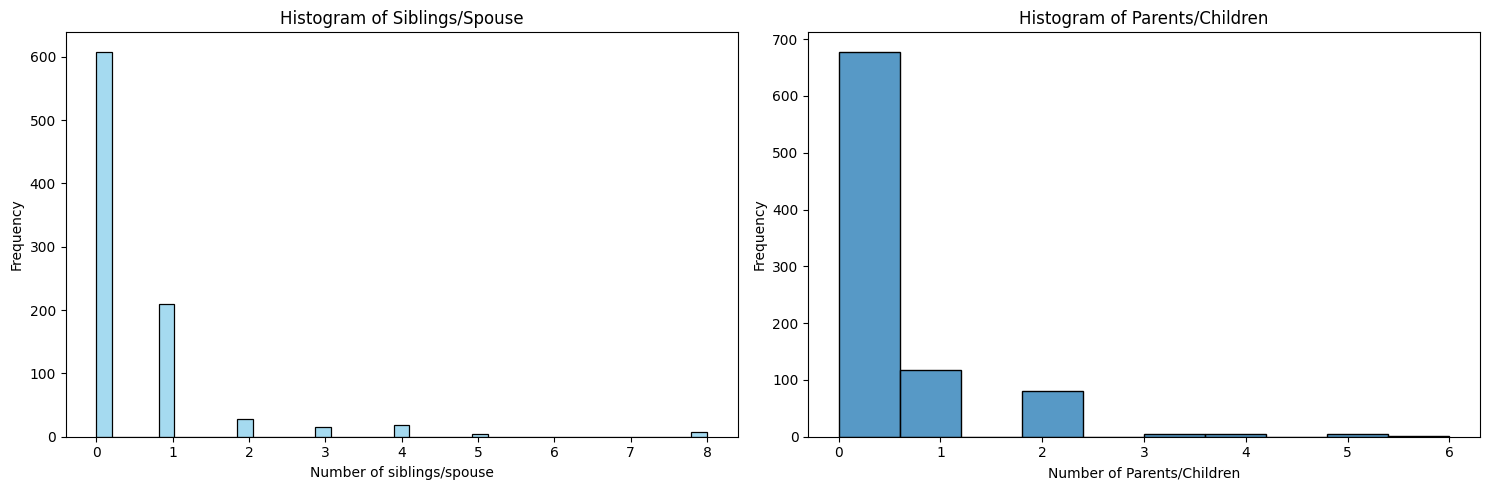

In [ ]:
# Create figure and axes objects
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot histograms for 'SibSp', 'Parch', and 'Age'
sns.histplot(passenger_df_train['SibSp'], ax=axs[0], color='skyblue', edgecolor='black', kde=False)
axs[0].set_title('Histogram of Siblings/Spouse')
axs[0].set_xlabel('Number of siblings/spouse')
axs[0].set_ylabel('Frequency')

sns.histplot(passenger_df_train['Parch'], ax=axs[1], edgecolor='black', bins=10, kde=False)
axs[1].set_title('Histogram of Parents/Children')
axs[1].set_xlabel('Number of Parents/Children')
axs[1].set_ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

### Observations in a Nutshell for all features seperately:

**passengers**:
1. There were 891 passengers in the data, with 681 unique tickets and 148 Cabins
2. Most passengers did not stay at a Cabin.

**sex**:
1. 65% of passengers are male and the rest female

**survived**:
1. 38% of passengers survived the disaster

**embarked**:
1. The majority of the passengers embarked from Southampton (makes sense because assumed higher population)
2. small amount of passengers have an unknown embarkment

**pclass**:
1. Most of the passengers are 3rd Class

**age**:
1. There are 177 passengers that have an unknown age
2. The average age is 23 and most of the passengers were in their 20's

**sibsp**:
1. 600+ passengers were without siblings/spouses
2. 1 Outlier of 8 siblings/spouse (probably the family members as each index)

**parch**:
1. The big majority of the passengers are without parents/children
2. No big outlier (max=6)
3. Mainly between 0-2

### Assumptions based on the data

**<u>Correlating</u>**

We want to know how well does each feature correlate with Survival.

**<u>Completing</u>**

1. We may want to complete Age feature as it is definitely correlated to survival.
2. We may want to complete the Embarked feature as it may also correlate with survival or another important feature.

**<u>Filtering</u>**

1. Ticket feature may be dropped from our analysis as it contains high ratio of duplicates (22%) and there may not be a correlation between Ticket and survival.
2. Cabin feature may be dropped as it is highly incomplete or contains many null values both in training and test dataset.
3. PassengerId may be dropped from training dataset as it does not contribute to survival.
4. Name feature is relatively non-standard, may not contribute directly to survival, so maybe dropped.

**<u>Engineering</u>**

1. We may want to create a new feature called Family based on Parch and SibSp to get total count of family members on board.
2. We may want to engineer the Name feature to extract Title as a new feature.
3. We may want to create new feature for Age bands. This turns a continous numerical feature into an ordinal categorical feature.
4. We may also want to create a Fare range feature if it helps our analysis.
5. We may want to divide the Cabin into Letter and number of cabin instead of filtering the feature completely to get further information.

**<u>Classifying</u>**

We may also add to our assumptions based on the problem description noted earlier.

1. Women (Sex=female) were more likely to have survived.
2. Children (Age<?) were more likely to have survived.
3. The upper-class passengers (Pclass=1) were more likely to have survived.

### Data Exploration

To confirm some of our observations and assumptions, we can quickly analyze our feature correlations by pivoting features against each other. We can only do so at this stage for features which do not have any empty values. It also makes sense doing so only for features which are categorical (Sex), ordinal (Pclass) or discrete (SibSp, Parch) type.

- **Pclass** We observe significant correlation (>0.5) among Pclass=1 and Survived (classifying #3). We decide to include this feature in our model.
- **Sex** We confirm the observation during problem definition that Sex=female had very high survival rate at 74% (classifying #1).
- **SibSp and Parch** These features have zero correlation for certain values. It may be best to derive a feature or a set of features from these individual features (engineering #1).

#### Comparing non-null features to survived

In [ ]:
# Your DataFrame and calculation
data = passenger_df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

# Create a bar plot using Plotly Express
fig = px.bar(data, x='Pclass', y='Survived', title='Survival Rate by Passenger Class',
             labels={'Pclass': 'Passenger Class', 'Survived': 'Survival Rate'},
             color='Survived', color_continuous_scale='blues')

# Update layout
fig.update_layout(xaxis=dict(tickmode='linear'), yaxis_tickformat='%')

# Show the plot
fig.show()

In [ ]:
# Your DataFrame and calculation
data = passenger_df_train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

# Create a bar plot using Plotly Express
fig = px.bar(data, x='Sex', y='Survived', title='Survival Rate by Sex',
             labels={'Sex': 'Sex', 'Survived': 'Survival Rate'},
             color='Survived', color_continuous_scale='greens')

# Update layout
fig.update_layout(xaxis=dict(tickmode='linear'), yaxis_tickformat='%')

# Show the plot
fig.show()

In [ ]:
# Your DataFrame and calculation
data = passenger_df_train[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

# Create a bar plot using Plotly Express
fig = px.bar(data, x='SibSp', y='Survived', title='Survival Rate by number of siblings/spouses',
             labels={'SibSp': 'Siblings/Spouse', 'Survived': 'Survival Rate'},
             color='Survived', color_continuous_scale='purples')

# Update layout
fig.update_layout(xaxis=dict(tickmode='linear'), yaxis_tickformat='%')

# Show the plot
fig.show()

In [ ]:
# Your DataFrame and calculation
data = passenger_df_train[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

# Create a bar plot using Plotly Express
fig = px.bar(data, x='Parch', y='Survived', title='Survival Rate by number of children/parents',
             labels={'Parch': 'parents/children', 'Survived': 'Survival Rate'},
             color='Survived', color_continuous_scale='reds')

# Update layout
fig.update_layout(xaxis=dict(tickmode='linear'), yaxis_tickformat='%')

# Show the plot
fig.show()

In [ ]:
# Define bins for the histogram
bins = np.linspace(passenger_df_train['Age'].min(), passenger_df_train['Age'].max(), 20)

# Create subplots
fig = subplots.make_subplots(rows=1, cols=2, subplot_titles=("Survived=0", "Survived=1"))

# Create histograms for each subplot
for survived_val in [0, 1]:
    age_data = passenger_df_train[passenger_df_train['Survived'] == survived_val]['Age']
    histogram = go.Histogram(x=age_data, histnorm='percent', name=f'Survived={survived_val}', xbins=dict(start=min(bins), end=max(bins), size=(max(bins)-min(bins))/len(bins)))
    fig.add_trace(histogram, row=1, col=survived_val + 1)

# Update layout
fig.update_layout(title_text="Distribution of Age by Survival",
                  xaxis_title="Age",
                  yaxis_title="Percentage",
                  showlegend=True)

# Show the plot
fig.show()


#### Based on the Age vs Survived Histograms:

**<u>Observations</u>**

- Infants (Age <=4) had high survival rate.
- Large number of 15-25 year olds did not survive.
- Most passengers are in 15-35 age range.

**<u>Decisions</u>**

- We should consider Age (classifying #2) in our model training.
- Complete the Age feature for null values (completing #1).
- We should band age groups (engineering #3).

In [ ]:
# Create subplots
fig = subplots.make_subplots(rows=3, cols=2, subplot_titles=("Pclass=1, Survived=0", "Pclass=1, Survived=1",
                                                            "Pclass=2, Survived=0", "Pclass=2, Survived=1",
                                                            "Pclass=3, Survived=0", "Pclass=3, Survived=1"))

# Create histograms for each subplot
for pclass_val in [1, 2, 3]:
    for survived_val in [0, 1]:
        age_data = passenger_df_train[(passenger_df_train['Pclass'] == pclass_val) & (passenger_df_train['Survived'] == survived_val)]['Age']
        histogram = go.Histogram(x=age_data, histnorm='percent', name=f'Pclass={pclass_val}, Survived={survived_val}', xbins=dict(start=passenger_df_train['Age'].min(), end=passenger_df_train['Age'].max(), size=5))
        fig.add_trace(histogram, row=pclass_val, col=survived_val + 1)

# Update layout
fig.update_layout(title_text="Distribution of Age by Pclass and Survival",
                  xaxis_title="Age",
                  yaxis_title="Percentage",
                  height=900, width=1000)

# Show the plot
fig.show()

#### Based on the Pclass vs Survived Histograms:

**<u>Observations</u>**

- Pclass=3 had most passengers, however most did not survive. Confirms our classifying assumption #2.
- Oldest passengers (Age = 80) survived.
- Infant passengers in Pclass=2 and Pclass=3 mostly survived. Further qualifies our classifying assumption #2.
- Most passengers in Pclass=1 survived. Confirms our classifying assumption #3.
- Pclass varies in terms of Age distribution of passengers.

**<u>Decisions</u>**

- Consider Pclass for model training.

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:718: UserWarning:

Using the pointplot function without specifying `order` is likely to produce an incorrect plot.

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:723: UserWarning:

Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.



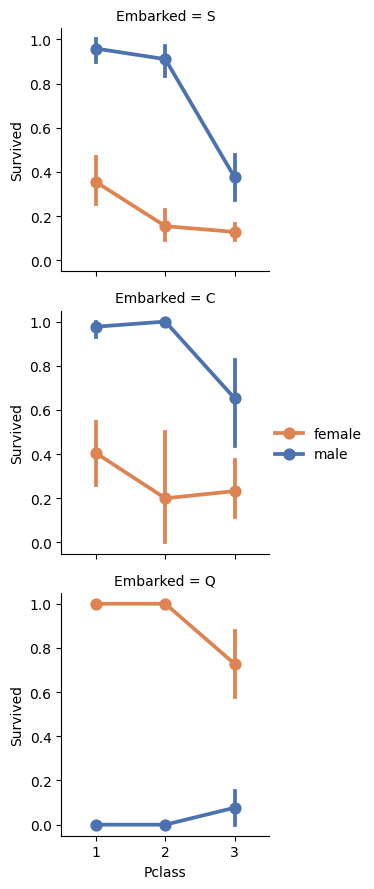

In [ ]:
grid = sns.FacetGrid(passenger_df_train, row='Embarked')
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

#### Based on the Pclass vs Survived vs Sex based on Embarked pointplots:

**<u>Observations</u>**

- Female passengers had much better survival rate than males. Confirms classifying (#1).
- Exception in Embarked=C where males had higher survival rate. This could be a correlation between Pclass and Embarked and in turn Pclass and Survived, not necessarily direct correlation between Embarked and Survived.
- Males had better survival rate in Pclass=3 when compared with Pclass=2 for C and Q ports. Completing (#2).
- Ports of embarkation have varying survival rates for Pclass=3 and among male passengers. Correlating (#1).

**<u>Decisions</u>**

- Add Sex feature to model training.
- Complete and add Embarked feature to model training.

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:718: UserWarning:

Using the barplot function without specifying `order` is likely to produce an incorrect plot.



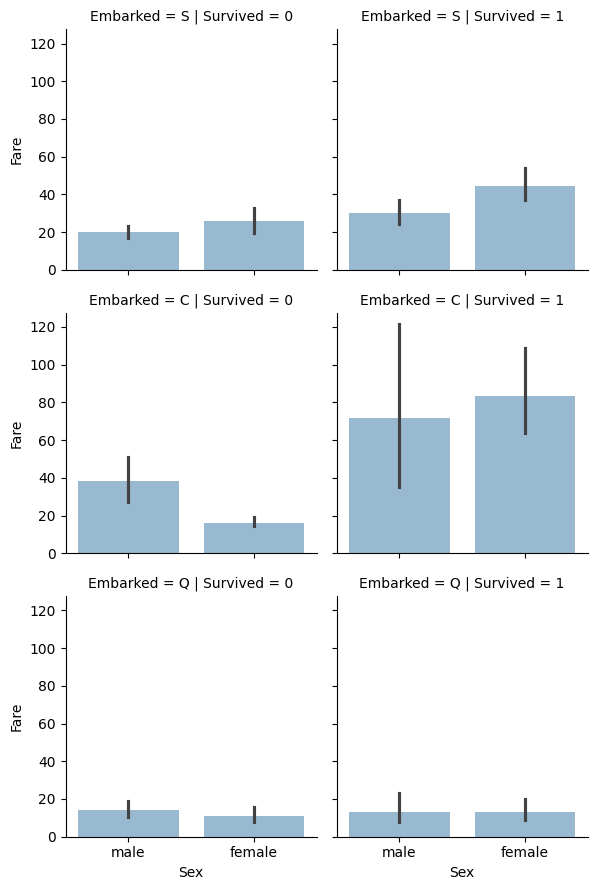

In [ ]:
grid = sns.FacetGrid(passenger_df_train, row='Embarked', col='Survived')
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5)
grid.add_legend()

#### Based on the Sex vs Fare vs Embarked vs Survived Barplots:

**<u>Observations</u>**

- Higher fare paying passengers had better survival. Confirms our assumption for creating (#4) fare ranges.
- Port of embarkation correlates with survival rates. Confirms correlating (#1) and completing (#2).

**<u>Decisions</u>**

- Consider banding Fare feature.

In [ ]:
cabin_divide = passenger_df_train.copy()
cabin_divide['cabin_multiple'] = cabin_divide.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))

# letters
# multiple letters
cabin_divide['cabin_multiple'].value_counts()

cabin_multiple
0    687
1    180
2     16
3      6
4      2
Name: count, dtype: int64

In [ ]:
px.histogram(data_frame= cabin_divide, x="cabin_multiple", color="Survived",title='Histogram of Number of Cabins and Suvived')

In [ ]:
#creates categories based on the cabin letter (n stands for null)
#in this case we will treat null values like it's own category

cabin_divide['cabin_deck'] = cabin_divide.Cabin.apply(lambda x: str(x)[0])

#comparing survival rate by cabin
print(cabin_divide.cabin_deck.value_counts())
pd.pivot_table(cabin_divide,index='Survived',columns='cabin_deck', values = 'Name', aggfunc='count')

cabin_deck
n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: count, dtype: int64


cabin_deck,A,B,C,D,E,F,G,T,n
Survived,,,,,,,,,
0,8.0,12.0,24.0,8.0,8.0,5.0,2.0,1.0,481.0
1,7.0,35.0,35.0,25.0,24.0,8.0,2.0,NaN,206.0


#### Based on the Cabins Pivot Tables:

**<u>Observations</u>**

- Passengers with at least a Cabin listed to there ticket have a higher chance of surviving. Confirms engineering (#5)
- Cabin titles B,C,D,E and F have a higher chance of survival. Confirms engineering (#5) and debunks Filtering (#2)

**<u>Decisions</u>**

- Consider Seperating the cabin feature into only cabin letters.
- Consider creating a number of Cabins feature.

In [ ]:
fig = px.histogram(cabin_divide,
                   facet_col="cabin_deck",
                   x="Pclass",
                   color="Survived",
                   title='Histogram of Pclass vs Cabin Letter vs Who Survived',
                   facet_col_wrap=3,
                   height=600,
                   width=1000   )

# Show the plot
fig.show()

**Ages vs ParCh**

In [ ]:
## Filter the dataframe for ages between 0 and 18 and for 0 to 2 parents/children
#filtered_passenger_df = passenger_df[(passenger_df['Age'] >= 0) & (passenger_df['Age'] <= 18) & (passenger_df['Parch'] == 0) & (passenger_df['Parch'] <= 2)]

# Create scatter plot
#plt.figure(figsize=(20,10))
#sns.scatterplot(data=passenger_df, x="Age", y="Parch", hue="Survived", style='Survived', palette='pastel', s=200)
#plt.grid()
#plt.title('Scatter Plot of Age vs Parch for Ages and Parents/Children')
#plt.xlabel('Age')
#plt.ylabel('Number of Parents/Children')
#plt.show()
px.histogram(data_frame= passenger_df_train, facet_col="Parch", x="Age", color="Survived",title='Histogram of Ages in Parch')

### Exploration with no regard to Survival
For the purpose of this exploration and feature engineering I will unite training and testing data. The advantage of this is that I can perform same transformations on both datasets at the same time.
Since test set has all NaNs in Survived, I will mark it with "-1". This will later allow for splitting them back easily.  
During this exploration I will not touch "Survived" feature.  

In [ ]:
co = {
    "Pclass": [1, 2, 3],
}

In [ ]:
passenger_df.loc[passenger_df.Survived.isna(),"Survived"] = -1
passenger_df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
1305,-1.0,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1306,-1.0,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1307,-1.0,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S


#### Cabin

In [ ]:
passenger_df["HasCabin"] = ~passenger_df.Cabin.isnull() *1
px.histogram(passenger_df, x = "Pclass", color="HasCabin")

In [ ]:
interesting_passengers = [823,  831,  829,  828,  827,  826,  825,  822,  833,
                          584,  938,  600,  285,   24, 1266, 1185,  648,
                          1001, 129, 1180, 1213, 873, 1114, 67, 517, 346]

passenger_df.loc[interesting_passengers]


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HasCabin
PassengerId,,,,,,,,,,,,
823,0.0,1,"Reuchlin, Jonkheer. John George",male,38.0,0,0,19972,0.0000,NaN,S,0
831,1.0,3,"Yasbeck, Mrs. Antoni (Selini Alexander)",female,15.0,1,0,2659,14.4542,NaN,C,0
829,1.0,3,"McCormack, Mr. Thomas Joseph",male,NaN,0,0,367228,7.7500,NaN,Q,0
828,1.0,2,"Mallet, Master. Andre",male,1.0,0,2,S.C./PARIS 2079,37.0042,NaN,C,0
827,0.0,3,"Lam, Mr. Len",male,NaN,0,0,1601,56.4958,NaN,S,0
826,0.0,3,"Flynn, Mr. John",male,NaN,0,0,368323,6.9500,NaN,Q,0
825,0.0,3,"Panula, Master. Urho Abraham",male,2.0,4,1,3101295,39.6875,NaN,S,0
822,1.0,3,"Lulic, Mr. Nikola",male,27.0,0,0,315098,8.6625,NaN,S,0
833,0.0,3,"Saad, Mr. Amin",male,NaN,0,0,2671,7.2292,NaN,C,0


In [ ]:
#cabins = tickets.loc[~tickets.Cabin.isna()] #, ["Fare", "Pclass", "Embarked", "Ticket", "Cabin"]]


passenger_df.drop("cDeck cNum".split(" "),axis=1, inplace=True, errors='ignore')

#rx = r'(?P<cDeck>[A-Za-z/.]+)?(?P<cNum>\d+)?$'
rx = r'(?P<cDeck>[A-Za-z])(?:\s[A-Za-z])?(?P<cNum>\d+)?$'
tspl = passenger_df.Cabin.str.extract(rx)
passenger_df = passenger_df.join(tspl)

#---
# Why am I doing this step? F deck has slightly different cabins allocation.
# There is an F section in the aft of ship, which starts counting from number
# one again. To make these cabins conform to general structure of cabins
# numbering that I've accepted here, I increase cabin F33 number by 70,
# so the number indicates the cabin is in the aft of ship.
passenger_df.loc[passenger_df.Cabin == "F33","cNum"] = 103
#---


#cabins['cNumRand'] = np.random.randint(1, 140, cabins.shape[0])

passenger_df.loc[passenger_df.Fare.isna(),'Fare'] = 10



#cabins.loc[cabins.cNum.isna(), 'cNum'] = 0  # cabins.loc[cabins.cNum.isna(), 'Fare']
#cabins.cNum = cabins.cNum.astype(int)

#cabins.loc[cabins.cNum.isna(),'cNumRand']
passenger_df.loc[passenger_df.cDeck.isna(),'cDeck'] = 'n'
#passenger_df.loc[passenger_df.Cabin.isna(),'Cabin'] = '?'
#cabins.loc[cabins.tPref.isna(),'tPref'] = '_'




decks = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'n']


passenger_df.cDeck = pd.Categorical(passenger_df.cDeck,
                              categories=decks,
                              ordered=True)



Check that Deck and cabin got split correctly.

In [ ]:
passenger_df['cCheck'] =  (passenger_df['cDeck']).astype(str) +  passenger_df['cNum'].astype(str)
passenger_df.loc[passenger_df.cCheck=='nnan',"cCheck"] = np.NaN
check = passenger_df[~(passenger_df['Cabin'] == passenger_df['cCheck'])].sort_values("Cabin")

columns_of_interest =  "Pclass Name Sex Age Fare Cabin cCheck HasCabin cDeck cNum".split(" ")
check.loc[check["HasCabin"]==1, columns_of_interest ]

,Pclass,Name,Sex,Age,Fare,Cabin,cCheck,HasCabin,cDeck,cNum
PassengerId,,,,,,,,,,
680,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.00,512.3292,B51 B53 B55,B55,1,B,55
1235,1,"Cardeza, Mrs. James Warburton Martinez (Charlo...",female,58.00,512.3292,B51 B53 B55,B55,1,B,55
873,1,"Carlsson, Mr. Frans Olof",male,33.00,5.0000,B51 B53 B55,B55,1,B,55
1264,1,"Ismay, Mr. Joseph Bruce",male,49.00,0.0000,B52 B54 B56,B56,1,B,56
1034,1,"Ryerson, Mr. Arthur Larned",male,61.00,262.3750,B57 B59 B63 B66,B66,1,B,66
743,1,"Ryerson, Miss. Susan Parker ""Suzette""",female,21.00,262.3750,B57 B59 B63 B66,B66,1,B,66
956,1,"Ryerson, Master. John Borie",male,13.00,262.3750,B57 B59 B63 B66,B66,1,B,66
916,1,"Ryerson, Mrs. Arthur Larned (Emily Maria Borie)",female,48.00,262.3750,B57 B59 B63 B66,B66,1,B,66
312,1,"Ryerson, Miss. Emily Borie",female,18.00,262.3750,B57 B59 B63 B66,B66,1,B,66


Some cabins seem to not have splitted correctly. However, upon examining these cabins we can conclude that these are families occupying several cabins. Since the families occupies cabins very close to each other, our splitting is good enough. Those are only in 1st class.

#### Ticket/placement
Explore what we can find from ticket/ placement data.  
Columns involved:   
["Fare", "Cabin", "Pclass", "Embarked", "Ticket"]

In [ ]:
#tickets = passenger_df_train[["Fare", "Cabin", "Pclass", "Embarked", "Ticket"]]

passenger_df.drop("tPref tNum".split(" "),axis=1, inplace=True, errors='ignore')


rx = r'(?P<tPref>[A-Za-z/.\d]+\s(?:[A-Za-z.\d]+\s)?)?(?P<tNum>\d+)$'

tspl = passenger_df.Ticket.str.extract(rx)
passenger_df = passenger_df.join(tspl)

In [ ]:
passenger_df.loc[passenger_df['Ticket'] == "LINE", "tPref"] = "LINE"
passenger_df.loc[passenger_df['Ticket'] == "LINE", "tNum"] = 1
passenger_df.tNum = passenger_df.tNum.astype(int)
passenger_df.loc[passenger_df.tPref.isna(), "tPref"] = ''

Validate: all tickets got split correctly?

In [ ]:
passenger_df["tCheck"] =  (passenger_df['tPref']).fillna('') + "" +passenger_df['tNum'].astype(str)
passenger_df[passenger_df['Ticket'] != passenger_df["tCheck"]]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HasCabin,cDeck,cNum,cCheck,tPref,tNum,tCheck
PassengerId,,,,,,,,,,,,,,,,,,
180,0.0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S,0,n,NaN,NaN,LINE,1,LINE1
272,1.0,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S,0,n,NaN,NaN,LINE,1,LINE1
303,0.0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S,0,n,NaN,NaN,LINE,1,LINE1
598,0.0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S,0,n,NaN,NaN,LINE,1,LINE1


##### Analyzing ticket prefixes

In [ ]:
passenger_df.groupby("tPref").count().sort_values('Fare',ascending=False)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HasCabin,cDeck,cNum,cCheck,tNum,tCheck
tPref,,,,,,,,,,,,,,,,,
,957,957,957,957,753,957,957,957,957,211,955,957,957,207,211,957,957
PC,92,92,92,92,80,92,92,92,92,67,92,92,92,67,67,92,92
C.A.,46,46,46,46,43,46,46,46,46,2,46,46,46,2,2,46,46
SOTON/O.Q.,16,16,16,16,12,16,16,16,16,1,16,16,16,1,1,16,16
W./C.,14,14,14,14,9,14,14,14,14,1,14,14,14,1,1,14,14
STON/O 2.,14,14,14,14,14,14,14,14,14,0,14,14,14,0,0,14,14
CA.,12,12,12,12,2,12,12,12,12,0,12,12,12,0,0,12,12
A/5,12,12,12,12,9,12,12,12,12,0,12,12,12,0,0,12,12
SC/PARIS,11,11,11,11,8,11,11,11,11,1,11,11,11,1,1,11,11


In [ ]:
def tr(val):
    val = val.replace(".","")
    val = val.replace("/","")
    val = val.replace(" ","")
    val = val.replace("STON","")
    val = val.replace("SOTON","")
    val = val.replace("PARIS","")
    val = val.replace("Paris","")
    val = val.replace("Basle","")
    val = val.replace("AH","")
    return val


passenger_df['tPrefTr'] = passenger_df.tPref.apply(tr)

prefs = passenger_df.groupby('tPrefTr').count().sort_values('tPrefTr',ascending=True)
co["tPrefTr"]: prefs.index.values
prefs.index.values

array(['', 'A2', 'A4', 'A5', 'AQ3', 'AQ4', 'AS', 'C', 'CA', 'FC', 'FCC',
       'Fa', 'LINE', 'LP', 'O2', 'OQ', 'PC', 'PP', 'PPP', 'SC', 'SCA3',
       'SCA4', 'SCOW', 'SOC', 'SOP', 'SOPP', 'SP', 'SWPP', 'WC', 'WEP'],
      dtype=object)

In [ ]:
q = """
select Pclass, tPrefTr, tPref,  count(*) as cnt
from passenger_df
group by Pclass, tPrefTr, tPref
order by Pclass, tPrefTr, cnt desc
"""
ps.sqldf(q)

,Pclass,tPrefTr,tPref,cnt
0,1,,,224
1,1,FC,F.C.,3
2,1,PC,PC,92
3,1,WEP,WE/P,2
4,1,WEP,W.E.P.,2
5,2,,,184
6,2,CA,C.A.,31
7,2,CA,CA,2
8,2,CA,C.A./SOTON,1
9,2,FCC,F.C.C.,9


Unfortunately, I could not guess what most of these mean, and no clues was found on internet

##### Hypothesis: ticket number has meaning
During exploration I had an hipothesis that ticket number could somehow contain an encoding to placement of the passenger on the ship.
To explore this hypothesis, I created various plots of features that might be involved, such as:
- Ticket number
- Ticket prefix
- Fare
- Class
- Deck
- cabin number

Ticket numbers seem to be concentrated into several groups. Interet seems to suggest that these groups come from individual stores from which the tickets were purchased. The order inside group is probably the order in which the tickets were purchased, so probably not very relevant to current research.

For now I could not identify any interaction pattern of tickets numbers with other features.

Zooming down to only 2, 3 classes, I was wondering if cabin deck, number or side might somehow be "encoded" in Fare and ticket number. But the data is too sparse to make any judjement on that.

In [ ]:
passenger_df['ClassDeck'] = passenger_df['Pclass'].astype(str) + passenger_df['cDeck'].astype(str)

co["ClassDeck"] =  passenger_df["ClassDeck"].sort_values(ascending=False).unique()

px.scatter(passenger_df, x = "tNum", y = "Fare", color="ClassDeck", facet_col="HasCabin", \
           color_discrete_sequence= px.colors.sequential.Rainbow, category_orders=co ) #, facet_col= "Survived")

#### Age

In [ ]:
passenger_df[passenger_df.Age.isna()].shape[0] / passenger_df.shape[0]

0.20091673032849502

We see that about 20% of passengers have no age registered. Maybe it could be estimated from other features?

#### Name
There appears to be a lot of information that can be extracted from passengers names.  
First, let's see what tokens beside names we can expect to see in this column

In [ ]:
def spl(n):
    return  n.split(" ")

In [ ]:
names = passenger_df_train.Name.apply(func=spl).values.tolist()
words = sum(names,[])

unique, counts = np.unique(words, return_counts=True)
wc = pd.DataFrame({"word":unique, "count": counts})
wc

tokens = wc.sort_values("count",ascending=False)
tokens.head(20)

,word,count
1153,Mr.,517
1122,Miss.,182
1154,Mrs.,125
1633,William,62
858,John,44
1068,Master.,40
758,Henry,33
828,James,24
382,Charles,23
645,George,22


In [ ]:
tokens.loc[tokens.word.str.contains("\.", ),"count"].sum()/ passenger_df.shape[0]

0.6814362108479756

We see that people titles have high token frequencies, suggesting that lots of people have them. Specifically, 68% of the people have them.  
Moreover, the Name column appears to have a very consistent structure:  
`Last_name, Title. First_Name (Second_Name)`  
This allows to relatively easy split the Name column into its components.

In [ ]:
# family = passenger_df_train["Fare Name Sex Age SibSp Parch Pclass".split(" ")]

# prev versions of regex
# rx = r'(?P<tPref>[A-Za-z/.\d]+\s(?:[A-Za-z.\d]+\s)?)?(?P<tNum>\d+)$'
# rx =  r'(?P<lName>[A-Za-z\s]+),\s(?P<title>[A-Za-z]+).(?P<fName>[A-Za-z\s]+)'
# rx += r'(?:(?P<sName>\s\([A-Za-z\s]+)\))$'
# rx = r"^(?P<lName>[A-Za-z\s'-]+),\s(?P<title>[A-Za-z]+)\.(\s(?P<fName>[A-Za-z\s\"]+))?(\s\((?P<sName>[A-Za-z\s\"-'\.]+)\).*)?$"


passenger_df.drop("lName Title fName sName".split(" "),axis=1, inplace=True, errors='ignore')

rx = r"^(?P<lName>[A-Za-z\s'-]+),\s(?P<Title>[A-Za-z\s]+)\.(?:\s(?P<fName>[A-Za-z\s\/\"]+))?(?:\s\((?P<sName>[A-Za-z\s\"'\.-]+)\).*)?$"

nspl = passenger_df.Name.str.extract(rx)

passenger_df = passenger_df.join(nspl)

passenger_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 1 to 1309
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Survived   1309 non-null   float64 
 1   Pclass     1309 non-null   int64   
 2   Name       1309 non-null   object  
 3   Sex        1309 non-null   object  
 4   Age        1046 non-null   float64 
 5   SibSp      1309 non-null   int64   
 6   Parch      1309 non-null   int64   
 7   Ticket     1309 non-null   object  
 8   Fare       1309 non-null   float64 
 9   Cabin      295 non-null    object  
 10  Embarked   1307 non-null   object  
 11  HasCabin   1309 non-null   int64   
 12  cDeck      1309 non-null   category
 13  cNum       289 non-null    object  
 14  cCheck     295 non-null    object  
 15  tPref      1309 non-null   object  
 16  tNum       1309 non-null   int64   
 17  tCheck     1309 non-null   object  
 18  tPrefTr    1309 non-null   object  
 19  ClassDeck  1309 non-null   objec

##### Title

In [ ]:
q = """
select Title, count(*) as cnt
from passenger_df
group by Title
order by cnt desc
"""
ps.sqldf(q)

,Title,cnt
0,Mr,757
1,Miss,260
2,Mrs,197
3,Master,61
4,Rev,8
5,Dr,8
6,Col,4
7,Ms,2
8,Mlle,2
9,Major,2


**Most titles are Mr, Mrs, Miss and Master. This may be used to estimate age where it's unknown**

There are several military titles, as well as other relarted to person's occupation. These can be joined into a single category Rare:  
- Col, Major, Jonkeer, Capt.
- Rev is Reverend - a member of clergy  
- Dr is Doctor  

Some titles are the equivalent of Mr, Mrs... in other languages or alternative spelling:  
 - Ms, Mlle = Miss  
 - Mme = Mrs

Several people have a noble title. But since they are few, they can be joined into Mr, Mrs category.  
 - the Countess, Lady, Dona = Mrs  
 - Don, Sir = Mr  


In [ ]:
show = "Fare Name Sex Age SibSp Parch Pclass lName Title fName sName".split(" ")
show = passenger_df.columns.isin(show)
show

array([False,  True,  True,  True,  True,  True,  True, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True,  True])

In [ ]:
passenger_df.loc[passenger_df.Title.isin(["Col", "Major", "Jonkheer", "Capt", "Dr", "Rev"]),show].sort_values("Age")

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,lName,Title,fName,sName
PassengerId,,,,,,,,,,,
399,2,"Pain, Dr. Alfred",male,23.0,0,0,10.5000,Pain,Dr,Alfred,NaN
887,2,"Montvila, Rev. Juozas",male,27.0,0,0,13.0000,Montvila,Rev,Juozas,NaN
849,2,"Harper, Rev. John",male,28.0,0,1,33.0000,Harper,Rev,John,NaN
1041,2,"Lahtinen, Rev. William",male,30.0,1,1,26.0000,Lahtinen,Rev,William,NaN
633,1,"Stahelin-Maeglin, Dr. Max",male,32.0,0,0,30.5000,Stahelin-Maeglin,Dr,Max,NaN
823,1,"Reuchlin, Jonkheer. John George",male,38.0,0,0,0.0000,Reuchlin,Jonkheer,John George,NaN
1056,2,"Peruschitz, Rev. Joseph Maria",male,41.0,0,0,13.0000,Peruschitz,Rev,Joseph Maria,NaN
150,2,"Byles, Rev. Thomas Roussel Davids",male,42.0,0,0,13.0000,Byles,Rev,Thomas Roussel Davids,NaN
246,1,"Minahan, Dr. William Edward",male,44.0,2,0,90.0000,Minahan,Dr,William Edward,NaN


In [ ]:
passenger_df.loc[passenger_df.Title.isin(["Col", "Major", "Jonkheer", "Capt", "Dr", "Rev"]), "Title"] = "Rare"
passenger_df.loc[passenger_df.Title.isin(["Mme", "the Countess", "Lady", "Dona"]), "Title"] = "Mrs"
passenger_df.loc[passenger_df.Title.isin(["Ms", "Mlle"]), "Title"] = "Miss"
passenger_df.loc[passenger_df.Title.isin(["Don", "Sir"]), "Title"] = "Mr"

After the replacing we have just 5 categories in title:

In [ ]:
q = """
select Title, count(*) as cnt
from passenger_df
group by Title
order by cnt desc
"""
ps.sqldf(q)

,Title,cnt
0,Mr,759
1,Miss,264
2,Mrs,201
3,Master,61
4,Rare,24


##### Second name
Let's explore the second name:

In [ ]:
passenger_df.loc[~passenger_df.sName.isna(),show]

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,lName,Title,fName,sName
PassengerId,,,,,,,,,,,
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,Cumings,Mrs,John Bradley,Florence Briggs Thayer
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,Futrelle,Mrs,Jacques Heath,Lily May Peel
9,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,11.1333,Johnson,Mrs,Oscar W,Elisabeth Vilhelmina Berg
10,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,30.0708,Nasser,Mrs,Nicholas,Adele Achem
16,2,"Hewlett, Mrs. (Mary D Kingcome)",female,55.0,0,0,16.0000,Hewlett,Mrs,NaN,Mary D Kingcome
...,...,...,...,...,...,...,...,...,...,...,...
1283,1,"Lines, Mrs. Ernest H (Elizabeth Lindsey James)",female,51.0,0,1,39.4000,Lines,Mrs,Ernest H,Elizabeth Lindsey James
1287,1,"Smith, Mrs. Lucien Philip (Mary Eloise Hughes)",female,18.0,1,0,60.0000,Smith,Mrs,Lucien Philip,Mary Eloise Hughes
1289,1,"Frolicher-Stehli, Mrs. Maxmillian (Margaretha ...",female,48.0,1,1,79.2000,Frolicher-Stehli,Mrs,Maxmillian,Margaretha Emerentia Stehli


We perform a similar token analysis  with these as before

In [ ]:
names = passenger_df.sName.astype(str).apply(func=spl).values.tolist()
words = sum(names,[])

unique, counts = np.unique(words, return_counts=True)
wc = pd.DataFrame({"word":unique, "count": counts})
tokens = wc.sort_values("count",ascending=False)
tokens.head(20)

,word,count
407,nan,1088
272,Mary,13
117,Elizabeth,12
264,Maria,8
33,Anna,7
106,E,6
36,Annie,5
75,Catherine,5
16,Ada,5
261,Margaret,5


In [ ]:
passenger_df[passenger_df.sName.astype(str).str.contains("Mr")]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,cCheck,tPref,tNum,tCheck,tPrefTr,ClassDeck,lName,Title,fName,sName
PassengerId,,,,,,,,,,,,,,,,,,,,,
188,1.0,1,"Romaine, Mr. Charles Hallace (""Mr C Rolmane"")",male,45.0,0,0,111428,26.5500,NaN,...,NaN,,111428,111428,,1n,Romaine,Mr,Charles Hallace,"""Mr C Rolmane"""
200,0.0,2,"Yrois, Miss. Henriette (""Mrs Harbeck"")",female,24.0,0,0,248747,13.0000,NaN,...,NaN,,248747,248747,,2n,Yrois,Miss,Henriette,"""Mrs Harbeck"""
428,1.0,2,"Phillips, Miss. Kate Florence (""Mrs Kate Louis...",female,19.0,0,0,250655,26.0000,NaN,...,NaN,,250655,250655,,2n,Phillips,Miss,Kate Florence,"""Mrs Kate Louise Phillips Marshall"""
600,1.0,1,"Duff Gordon, Sir. Cosmo Edmund (""Mr Morgan"")",male,49.0,1,0,PC 17485,56.9292,A20,...,A20,PC,17485,PC 17485,PC,1A,Duff Gordon,Mr,Cosmo Edmund,"""Mr Morgan"""
605,1.0,1,"Homer, Mr. Harry (""Mr E Haven"")",male,35.0,0,0,111426,26.5500,NaN,...,NaN,,111426,111426,,1n,Homer,Mr,Harry,"""Mr E Haven"""
706,0.0,2,"Morley, Mr. Henry Samuel (""Mr Henry Marshall"")",male,39.0,0,0,250655,26.0000,NaN,...,NaN,,250655,250655,,2n,Morley,Mr,Henry Samuel,"""Mr Henry Marshall"""
711,1.0,1,"Mayne, Mlle. Berthe Antonine (""Mrs de Villiers"")",female,24.0,0,0,PC 17482,49.5042,C90,...,C90,PC,17482,PC 17482,PC,1C,Mayne,Miss,Berthe Antonine,"""Mrs de Villiers"""
1036,-1.0,1,"Lindeberg-Lind, Mr. Erik Gustaf (Mr Edward Lin...",male,42.0,0,0,17475,26.5500,NaN,...,NaN,,17475,17475,,1n,Lindeberg-Lind,Mr,Erik Gustaf,"Mr Edward Lingrey"""
1219,-1.0,1,"Rosenshine, Mr. George (Mr George Thorne"")""",male,46.0,0,0,PC 17585,79.2000,NaN,...,NaN,PC,17585,PC 17585,PC,1n,Rosenshine,Mr,George,"Mr George Thorne"""


Seems like majority of these contain full/maiden names of women travelling with ticket under their husbands' names.  
Maybe this property could be used for Age estimation...

#### Family composition data

In [ ]:
passenger_df["SexClass"] =  passenger_df["Pclass"].astype(str) + passenger_df["Sex"]

co["SexClass"] = passenger_df["SexClass"].sort_values().unique()
co["Parch"] = [0,1,2,3,4,5,6,7,8,9]

px.scatter(passenger_df, x = "Age", y = "Parch", color="Title", hover_data=["Fare"], \
          category_orders=co, height= 600 ) #, facet_col= "Survived")

We clearly see that the titles Master and Miss, along with the amount of parents and siblings, can serve as a good indicator for people's age

#### Some interaction variables

In [ ]:
passenger_df["EmbClass"] = passenger_df.Pclass.astype(str) + passenger_df.Embarked
co["EmbClass"] = passenger_df["EmbClass"].sort_values().unique()
co["EmbClass"]

array(['1C', '1Q', '1S', '2C', '2Q', '2S', '3C', '3Q', '3S', nan],
      dtype=object)

In [ ]:

fig = px.scatter(passenger_df, x = "tNum", y = "Fare", color="cNum", facet_col = "HasCabin", \
                 hover_data=[passenger_df.index,"Cabin","Embarked","Fare","Pclass","cNum", "tPrefTr"], \
                 height=600, category_orders=co, \
                 color_discrete_sequence= px.colors.sequential.Rainbow,\
                 #color_discrete_sequence= cmap,
                )

fig.update_xaxes(categoryorder='category ascending')
fig.update_traces(marker_size = 3)
fig.update_yaxes(tickformat="%f")
fig.update_xaxes(tickformat="%f")

### Part 2 - Data Engineering + Encoding Categorical Values

### Data Imputation

As discussed in Exploration section, about 20% of passengers have no Are registered. We would like to impute the null values of Age with an estimation based on other variables.

But first, there is one person without Fare. We'll just put a number manually there.

In [ ]:
passenger_df.loc[passenger_df.Fare.isna(), "Fare"] = 7.2500

Prepare dataset for training and imputation

In [ ]:
Cx = ["Fare", "Sex", "SibSp", "Parch", "Pclass", "Title"]
Cy = "Age"
categorical_columns = ["Sex", "Title"]

# Convert categorical variables into dummy variables using one-hot encoding
X = pd.get_dummies(passenger_df[Cx], columns=categorical_columns)
y = passenger_df[Cy]
X


,Fare,SibSp,Parch,Pclass,Sex_female,Sex_male,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
PassengerId,,,,,,,,,,,
1,7.2500,1,0,3,False,True,False,False,True,False,False
2,71.2833,1,0,1,True,False,False,False,False,True,False
3,7.9250,0,0,3,True,False,False,True,False,False,False
4,53.1000,1,0,1,True,False,False,False,False,True,False
5,8.0500,0,0,3,False,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...
1305,8.0500,0,0,3,False,True,False,False,True,False,False
1306,108.9000,0,0,1,True,False,False,False,False,True,False
1307,7.2500,0,0,3,False,True,False,False,True,False,False


Select rows with missing values for 'Age' in target. Those will be imputed

In [ ]:
Ximp = X[y.isna()]
yimp = y[y.isna()]
Ximp

,Fare,SibSp,Parch,Pclass,Sex_female,Sex_male,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
PassengerId,,,,,,,,,,,
6,8.4583,0,0,3,False,True,False,False,True,False,False
18,13.0000,0,0,2,False,True,False,False,True,False,False
20,7.2250,0,0,3,True,False,False,False,False,True,False
27,7.2250,0,0,3,False,True,False,False,True,False,False
29,7.8792,0,0,3,True,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
1300,7.7208,0,0,3,True,False,False,True,False,False,False
1302,7.7500,0,0,3,True,False,False,True,False,False,False
1305,8.0500,0,0,3,False,True,False,False,True,False,False


Select rows with existing values for 'Age' in target. Those will be used to learn the pattern for imputation

In [ ]:
X = X[~y.isna()]
y = y[~y.isna()]
X

,Fare,SibSp,Parch,Pclass,Sex_female,Sex_male,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
PassengerId,,,,,,,,,,,
1,7.2500,1,0,3,False,True,False,False,True,False,False
2,71.2833,1,0,1,True,False,False,False,False,True,False
3,7.9250,0,0,3,True,False,False,True,False,False,False
4,53.1000,1,0,1,True,False,False,False,False,True,False
5,8.0500,0,0,3,False,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...
1301,13.7750,1,1,3,True,False,False,True,False,False,False
1303,90.0000,1,0,1,True,False,False,False,False,True,False
1304,7.7750,0,0,3,True,False,False,True,False,False,False


Train, validation, test split

In [ ]:
def i_trn_tst_val(X, test_size=0.1):
    i_trn, i_tst =  next(model_selection.ShuffleSplit(test_size=test_size, random_state=42).split(X))
    i_trn, i_val =  next(model_selection.ShuffleSplit(test_size=2*test_size, random_state=42).split(X.iloc[i_trn]))
    return i_trn, i_val, i_tst

In [ ]:
i_trn, i_val, i_tst = i_trn_tst_val(X)

#### Cross-validate ensemble models
This convenience function will be used for training, evaluation  and summarization  of various ML models.  
At this stage we will concentrate on ensemble family of models

In [ ]:
import os
newpath = r'CV_Runs'
if not os.path.exists(newpath):
    os.makedirs(newpath)

In [ ]:
CV_Runs = []
def Run_and_Report(grid, X, y):
    grid.fit(X.iloc[i_trn], y.iloc[i_trn])
    params = grid.get_params()
    best = grid.best_estimator_
    cv_run = {
        "timestamp": datetime.now().strftime("%Y-%m-%d_%H-%M-%S"),
        "estimator": str(params['estimator']),
        "best_params": grid.best_params_,
        "train_score": best.score(X.iloc[i_trn], y.iloc[i_trn]),
        "val_score":   best.score(X.iloc[i_val], y.iloc[i_val]),
        "test_score":  best.score(X.iloc[i_tst], y.iloc[i_tst]),
        "cv": params['cv'],
        "n_iter": params["n_iter"],
        "n_jobs": params["n_jobs"],
        "CVmethod": type(grid).__name__,
        "param_grid": params['param_distributions'],
        "features": X.columns.tolist(),
        "target": y.name
    }
    CV_Runs.append(cv_run)
    with open(f"CV_Runs/{cv_run['timestamp']}.json", 'w') as f:
        json.dump(cv_run, f, default=lambda x: x.__repr__())
    return grid

Random Forest

In [ ]:
iterations = 1

In [ ]:
rfr = RandomForestRegressor()

param_grid ={'max_depth': st.randint(6, 20),
             'n_estimators': st.randint(10, 500),
             'max_features': np.arange(5,12),
             'max_leaf_nodes': st.randint(6, 30)}

grid = model_selection.RandomizedSearchCV(rfr,
                    param_grid, cv=10,
                    verbose=1, n_iter=iterations, n_jobs=16 )

Run_and_Report(grid, X, y)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(), n_iter=1,
                   n_jobs=16,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a301111bd90>,
                                        'max_features': array([ 5,  6,  7,  8,  9, 10, 11]),
                                        'max_leaf_nodes': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a30110f0a60>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a30110f12d0>},
                   verbose=1)

AdaBoost

In [ ]:
abr = AdaBoostRegressor()
abr.get_params()

param_grid ={
    'learning_rate': st.randint(1, 10),
    'n_estimators': st.randint(10, 500),
}

grid = model_selection.RandomizedSearchCV(abr,
                    param_grid, cv=10,
                    verbose=1, n_iter=iterations, n_jobs=16 )

Run_and_Report(grid, X, y)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


RandomizedSearchCV(cv=10, estimator=AdaBoostRegressor(), n_iter=1, n_jobs=16,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a30110c8790>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a3011118040>},
                   verbose=1)

GradientBoosting

In [ ]:
gbr = GradientBoostingRegressor()
param_grid ={'max_depth': st.randint(6, 20),
             'n_estimators': st.randint(10, 500),
             'max_features': np.arange(5,12),
             'max_leaf_nodes': st.randint(6, 30)}


grid = model_selection.RandomizedSearchCV(gbr,
                    param_grid, cv=10,
                    verbose=1, n_iter=iterations, n_jobs=16 )

Run_and_Report(grid, X, y)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


RandomizedSearchCV(cv=10, estimator=GradientBoostingRegressor(), n_iter=1,
                   n_jobs=16,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a30110c84f0>,
                                        'max_features': array([ 5,  6,  7,  8,  9, 10, 11]),
                                        'max_leaf_nodes': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a301109f5e0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a301109f4f0>},
                   verbose=1)

In [ ]:
CV_df = pd.DataFrame(CV_Runs)
CV_df

,timestamp,estimator,best_params,train_score,val_score,test_score,cv,n_iter,n_jobs,CVmethod,param_grid,features,target
0,2024-04-29_17-05-14,RandomForestRegressor(),"{'max_depth': 7, 'max_features': 6, 'max_leaf_...",0.540718,0.377933,0.541189,10,1,16,RandomizedSearchCV,{'max_depth': <scipy.stats._distn_infrastructu...,"[Fare, SibSp, Parch, Pclass, Sex_female, Sex_m...",Age
1,2024-04-29_17-05-24,AdaBoostRegressor(),"{'learning_rate': 3, 'n_estimators': 137}",0.419309,0.334826,0.364841,10,1,16,RandomizedSearchCV,{'learning_rate': <scipy.stats._distn_infrastr...,"[Fare, SibSp, Parch, Pclass, Sex_female, Sex_m...",Age
2,2024-04-29_17-05-30,GradientBoostingRegressor(),"{'max_depth': 12, 'max_features': 7, 'max_leaf...",0.808069,0.192592,0.622510,10,1,16,RandomizedSearchCV,{'max_depth': <scipy.stats._distn_infrastructu...,"[Fare, SibSp, Parch, Pclass, Sex_female, Sex_m...",Age


In [ ]:
# TODO: fix this plot

In [ ]:
fig = px.scatter(CV_df, x="timestamp", y="train_score", color="estimator")
fig.show()

In [ ]:
fig.add_trace( go.Scatter(x=CV_df["timestamp"], y=CV_df["val_score"], name="val_score", )) #, fill=CV_df["estimator"]))
fig.add_trace( go.Scatter(x=CV_df["timestamp"], y=CV_df["test_score"], name="test_score")) #, fill=CV_df["estimator"]))
fig.show()

### Estimate missing ages
Based on the benchmarking results above, we decided to choose model 3 (GradientBoostingRegressor)

In [ ]:
df = CV_df.loc[2,["estimator", "best_params"]]
with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):  # more options can be specified also
    print(df)

estimator                                                          GradientBoostingRegressor()
best_params    {'max_depth': 12, 'max_features': 7, 'max_leaf_nodes': 22, 'n_estimators': 316}
Name: 2, dtype: object


In [ ]:
best_params = {'max_depth': 13, 'max_features': 5, 'max_leaf_nodes': 29, 'n_estimators': 435}

rfc = GradientBoostingRegressor( **best_params)
rfc.fit(X,y)
y_hat = rfc.predict(Ximp)
y_hat = pd.Series(rfc.predict(Ximp), index=Ximp.index)
y_hat

PassengerId
6       22.317599
18      32.222259
20      44.644866
27      27.395147
29      21.790992
          ...    
1300    21.383428
1302    27.482777
1305    29.818269
1308    29.818269
1309     4.278389
Length: 263, dtype: float64

Impute the new predicted age values into original dataset

In [ ]:
passenger_df.loc[y_hat.index, "Age"] = y_hat.astype(int)
passenger_df["AgeEstimated"] = 0
passenger_df.loc[y_hat.index, "AgeEstimated"] = 1
px.histogram(passenger_df, x="Age", facet_col = "AgeEstimated")

In [ ]:
px.scatter(passenger_df, x = "Age", y = "Parch", color="Title", facet_col= "AgeEstimated", hover_data=["SibSp", "Fare", "Name"], \
          category_orders=co, height= 600 ) #, facet_col= "Survived")

It seems that imputation went quite well.

In [ ]:
passenger_df.Embarked.isna().sum()

2

In [ ]:
passenger_df_train = passenger_df[passenger_df.Survived != -1]
passenger_df_train

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,tCheck,tPrefTr,ClassDeck,lName,Title,fName,sName,SexClass,EmbClass,AgeEstimated
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,...,A/5 21171,A5,3n,Braund,Mr,Owen Harris,NaN,3male,3S,0
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,...,PC 17599,PC,1C,Cumings,Mrs,John Bradley,Florence Briggs Thayer,1female,1C,0
3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,...,STON/O2. 3101282,O2,3n,Heikkinen,Miss,Laina,NaN,3female,3S,0
4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,...,113803,,1C,Futrelle,Mrs,Jacques Heath,Lily May Peel,1female,1S,0
5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,...,373450,,3n,Allen,Mr,William Henry,NaN,3male,3S,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0.0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,...,211536,,2n,Montvila,Rare,Juozas,NaN,2male,2S,0
888,1.0,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,...,112053,,1B,Graham,Miss,Margaret Edith,NaN,1female,1S,0
889,0.0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,2.0,1,2,W./C. 6607,23.4500,NaN,...,W./C. 6607,WC,3n,Johnston,Miss,"Catherine Helen ""Carrie""",NaN,3female,3S,1


In [ ]:
passenger_df_test = passenger_df[passenger_df.Survived == -1].drop("Survived", axis=1)
passenger_df_test

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,...,tCheck,tPrefTr,ClassDeck,lName,Title,fName,sName,SexClass,EmbClass,AgeEstimated
PassengerId,,,,,,,,,,,,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,...,330911,,3n,Kelly,Mr,James,NaN,3male,3Q,0
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,...,363272,,3n,Wilkes,Mrs,James,Ellen Needs,3female,3S,0
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,...,240276,,2n,Myles,Mr,Thomas Francis,NaN,2male,2Q,0
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,...,315154,,3n,Wirz,Mr,Albert,NaN,3male,3S,0
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,...,3101298,,3n,Hirvonen,Mrs,Alexander,Helga E Lindqvist,3female,3S,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,3,"Spector, Mr. Woolf",male,29.0,0,0,A.5. 3236,8.0500,NaN,S,...,A.5. 3236,A5,3n,Spector,Mr,Woolf,NaN,3male,3S,1
1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,...,PC 17758,PC,1C,Oliva y Ocana,Mrs,Fermina,NaN,1female,1C,0
1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,...,SOTON/O.Q. 3101262,OQ,3n,Saether,Mr,Simon Sivertsen,NaN,3male,3S,0


### Construct More features

In [ ]:
passenger_df_train.Title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Rare'], dtype=object)

In [ ]:
# Gives the length of the name
passenger_df['Words_Count'] = passenger_df['Name'].apply(lambda x: len(x.split()))
print(passenger_df.Words_Count.value_counts())

Words_Count
4     558
3     449
5     144
6      81
7      59
8      16
14      1
9       1
Name: count, dtype: int64


In [ ]:
# Your DataFrame and calculation
data = passenger_df[passenger_df.Survived != -1][['Words_Count', 'Survived']].groupby(['Words_Count'], as_index=False).mean().sort_values(by='Survived', ascending=False)

# Create a bar plot using Plotly Express
fig = px.bar(data, x='Words_Count', y='Survived', title='Survival Rate by length of name',
             labels={'Words_Count': 'length of name', 'Survived': 'Survival Rate'},
             color='Survived', color_continuous_scale='blues')

# Update layout
fig.update_layout(xaxis=dict(tickmode='linear'), yaxis_tickformat='%')

# Show the plot
fig.show()

In [ ]:
#Create new features cabin_multiple and cabin_adv that shows number of each
passenger_df['cabin_multiple'] = passenger_df['Cabin'].apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
passenger_df['cabin_deck'] = passenger_df['Cabin'].apply(lambda x: str(x)[0])

# Create new feature FamilySize as a combination of SibSp and Parch
passenger_df['FamilySize'] = passenger_df['SibSp'] + passenger_df['Parch'] + 1
print(passenger_df[passenger_df.Survived != -1][['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False))

# Create new feature IsAlone from FamilySize
passenger_df['IsAlone'] = 0
passenger_df.loc[passenger_df['FamilySize'] == 1, 'IsAlone'] = 1
print(passenger_df[passenger_df.Survived != -1][['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean().sort_values(by='Survived', ascending=False))


   FamilySize  Survived
3           4  0.724138
2           3  0.578431
1           2  0.552795
6           7  0.333333
0           1  0.303538
4           5  0.200000
5           6  0.136364
7           8  0.000000
8          11  0.000000
   IsAlone  Survived
0        0  0.505650
1        1  0.303538


In [ ]:
# Remove all NULLS in the Fare column and Create new feature CategoricalFare
passenger_df['Fare'] = passenger_df['Fare'].fillna(passenger_df['Fare'].median())
passenger_df['CategoricalFare'] = pd.qcut(passenger_df['Fare'], 6)
passenger_df[passenger_df.Survived != -1][['CategoricalFare', 'Survived']].groupby(['CategoricalFare'], as_index=False).mean().sort_values(by='CategoricalFare', ascending=True)

,CategoricalFare,Survived
0,"(-0.001, 7.775]",0.205128
1,"(7.775, 8.662]",0.190789
2,"(8.662, 14.454]",0.366906
3,"(14.454, 26.0]",0.436242
4,"(26.0, 53.1]",0.435065
5,"(53.1, 512.329]",0.695035


Impute missing Age values with random

In [ ]:

#age_avg = passenger_df_train['Age'].mean()
#age_std = passenger_df_train['Age'].std()
#age_null_count = passenger_df_train['Age'].isnull().sum()
#age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
#age_null_random_list = pd.Series(age_null_random_list, index = passenger_df_train[passenger_df_train['Age'].isnull()].index)

#passenger_df_train["Age"].fillna(age_null_random_list, inplace=True)


Create a New feature CategoricalAge

In [ ]:
passenger_df['CategoricalAge'] = pd.qcut(passenger_df['Age'], 6)
passenger_df[passenger_df.Survived != -1][['CategoricalAge', 'Survived']].groupby(['CategoricalAge'], as_index=False).mean().sort_values(by='CategoricalAge', ascending=True)
passenger_df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SexClass,EmbClass,AgeEstimated,Words_Count,cabin_multiple,cabin_deck,FamilySize,IsAlone,CategoricalFare,CategoricalAge
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,...,3male,3S,0,4,0,n,2,0,"(-0.001, 7.775]","(18.5, 24.0]"
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,...,1female,1C,0,7,1,C,2,0,"(53.1, 512.329]","(34.0, 43.0]"
3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,...,3female,3S,0,3,0,n,1,1,"(7.775, 8.662]","(24.0, 28.0]"
4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,...,1female,1S,0,7,1,C,2,0,"(26.0, 53.1]","(34.0, 43.0]"
5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,...,3male,3S,0,4,0,n,1,1,"(7.775, 8.662]","(34.0, 43.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,-1.0,3,"Spector, Mr. Woolf",male,29.0,0,0,A.5. 3236,8.0500,NaN,...,3male,3S,1,3,0,n,1,1,"(7.775, 8.662]","(28.0, 34.0]"
1306,-1.0,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,...,1female,1C,0,5,1,C,1,1,"(53.1, 512.329]","(34.0, 43.0]"
1307,-1.0,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,...,3male,3S,0,4,0,n,1,1,"(-0.001, 7.775]","(34.0, 43.0]"


### Mapping Categorical and High Ordinal Features

In [ ]:
passenger_df['cabin_deck'].unique()

array(['n', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [ ]:

# Mapping Sex
passenger_df['Sex'] = passenger_df['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

# Mapping Titles
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
passenger_df['Title'] = passenger_df['Title'].map(title_mapping)
passenger_df['Title'] = passenger_df['Title'].fillna(0)



# Remove all NULLS in the Embarked column (2 nulls)
passenger_df['Embarked'] = passenger_df['Embarked'].fillna('S')
# Mapping Embarked
passenger_df['Embarked'] = passenger_df['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

# Mapping Cabin_adv
passenger_df['cabin_deck'] = passenger_df['cabin_deck'].map( {'n': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': 8} ).astype(int)

# Mapping Fare
passenger_df.loc[(passenger_df['Fare'] < 6), 'Fare'] = 0
passenger_df.loc[(passenger_df['Fare'] >= 6) & (passenger_df['Fare'] < 12), 'Fare'] = 1
passenger_df.loc[(passenger_df['Fare'] >= 12) & (passenger_df['Fare'] < 18), 'Fare'] = 2
passenger_df.loc[(passenger_df['Fare'] >= 18) & (passenger_df['Fare'] < 24), 'Fare'] = 3
passenger_df.loc[(passenger_df['Fare'] >= 24) & (passenger_df['Fare'] < 30), 'Fare'] = 4
passenger_df.loc[(passenger_df['Fare'] >= 30), 'Fare'] = 5
passenger_df['Fare'] = passenger_df['Fare'].astype(int)

# Mapping Age
passenger_df.loc[ passenger_df['Age'] < 18, 'Age'] 					       = 0
passenger_df.loc[(passenger_df['Age'] >= 18) & (passenger_df['Age'] < 23), 'Age'] = 1
passenger_df.loc[(passenger_df['Age'] >= 23) & (passenger_df['Age'] < 28), 'Age'] = 2
passenger_df.loc[(passenger_df['Age'] >= 28) & (passenger_df['Age'] < 34), 'Age'] = 3
passenger_df.loc[(passenger_df['Age'] >= 34) & (passenger_df['Age'] < 42), 'Age'] = 4
passenger_df.loc[ passenger_df['Age'] >= 42, 'Age'] = 5 ;

In [ ]:
passenger_df['Age*Class'] = passenger_df.Age * passenger_df.Pclass

passenger_df.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

,Age*Class,Age,Pclass
PassengerId,,,
1,3.0,1.0,3
2,4.0,4.0,1
3,6.0,2.0,3
4,4.0,4.0,1
5,12.0,4.0,3
6,3.0,1.0,3
7,5.0,5.0,1
8,0.0,0.0,3
9,6.0,2.0,3


### Feature Selection

In [ ]:
# Feature selection
drop_elements = ['Name', 'Ticket', 'Cabin', 'SibSp','HasCabin', 'AgeEstimated',
                 'cDeck', 'cNum', 'cCheck', 'tPref', 'tNum', 'tCheck', 'tPrefTr',
                 'ClassDeck', 'lName', 'Title', 'fName', 'sName', 'SexClass', 'EmbClass',]
#drop_elements = ['has_cabin', 'AgeEstimated']
passenger_df = passenger_df.drop(drop_elements, axis = 1, errors='ignore')
passenger_df = passenger_df.drop(['CategoricalAge', 'CategoricalFare'], axis = 1, errors='ignore')

In [ ]:
passenger_df.head(20)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Words_Count,cabin_multiple,cabin_deck,FamilySize,IsAlone,Age*Class
PassengerId,,,,,,,,,,,,,
1,0.0,3,1,1.0,0,1,0,4,0,0,2,0,3.0
2,1.0,1,0,4.0,0,5,1,7,1,3,2,0,4.0
3,1.0,3,0,2.0,0,1,0,3,0,0,1,1,6.0
4,1.0,1,0,4.0,0,5,0,7,1,3,2,0,4.0
5,0.0,3,1,4.0,0,1,0,4,0,0,1,1,12.0
6,0.0,3,1,1.0,0,1,2,3,0,0,1,1,3.0
7,0.0,1,1,5.0,0,5,0,4,1,5,1,1,5.0
8,0.0,3,1,0.0,1,3,0,4,0,0,5,0,0.0
9,1.0,3,0,2.0,2,1,0,7,0,0,3,0,6.0


In [ ]:
passenger_df_train = passenger_df[passenger_df.Survived != -1]

In [ ]:
passenger_df_corr=passenger_df_train.astype(float).corr()

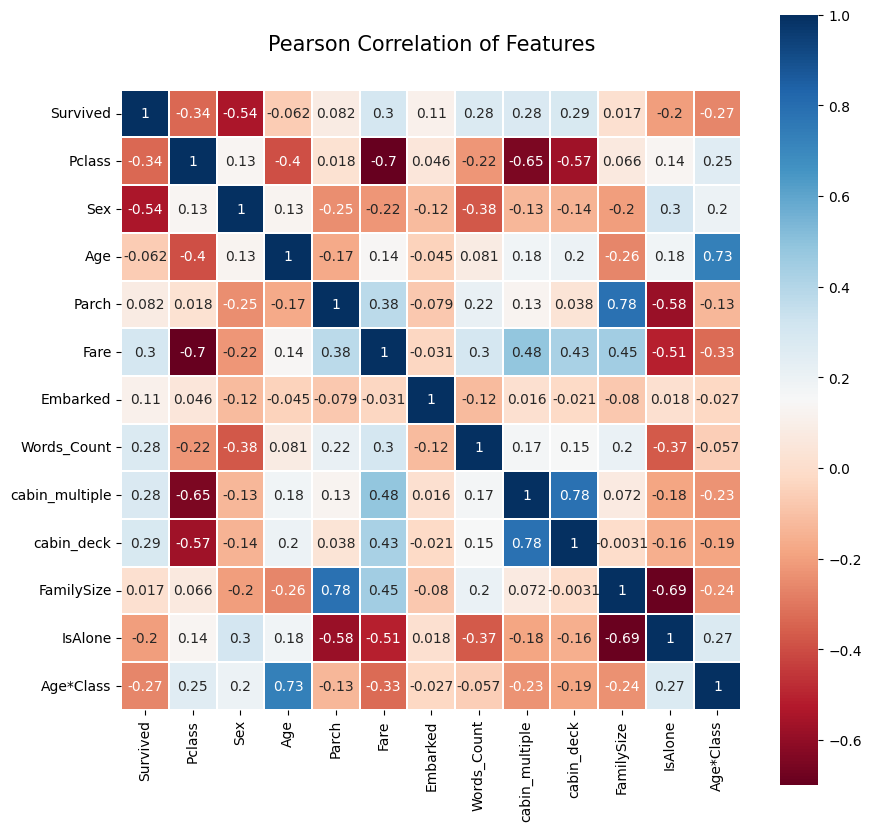

In [ ]:
colormap=plt.cm.RdBu
plt.figure(figsize=(10,10))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(passenger_df_corr,linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

### Takeaway from the Heatmap

There aren't many features strongly correlated with one another (highest is 0.78 between Parch and FamilySize and between the two cabin features. We'll still leave both features.) This is good from a point of view of feeding these features into your learning model because there isn't much redundant or superfluous data in our training set and we accept that each feature carries data with some unique information.

## Model Learning

### Splitting the passenger data 80/20

In [ ]:
X = passenger_df_train.drop('Survived', axis=1)
y = passenger_df_train['Survived']

# Splitting data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### Model Functions

#### Train and Evaluate models

In [ ]:
def train_and_evaluate_models(models, X_train, y_train, X_val, y_val, param_grids, scoring='accuracy', cv=10):
    results = {}
    evaluation_data = []  # Create a list to store evaluation data

    for model_name, model in models.items():
        param_grid = param_grids[model_name]

        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=cv)
        grid_search.fit(X_train, y_train)

        params = grid_search.cv_results_['params']
        scores = grid_search.cv_results_['mean_test_score']

        best_params = grid_search.best_params_
        best_score = grid_search.best_score_

        model.set_params(**best_params)
        model.fit(X_train, y_train)

        validation_score = model.score(X_val, y_val)

        results[model_name] = {
            'best_params': best_params,
            'best_score': best_score,
            'validation_score': validation_score
        }

        # Append evaluation data as a dictionary to the list
        evaluation_data.append({
            'Model': model_name,
            'Best Parameters': best_params,
            'Best Score (CV)': best_score,
            'Validation Score': validation_score
        })
        visualize_grid_search_results(param_grid, params, scores, best_params, best_score, model_name)
    # Create a DataFrame from the list of evaluation data
    evaluation_df = pd.DataFrame(evaluation_data)

    return results, evaluation_df

#### Visualize Results

In [ ]:
def visualize_grid_search_results(param_grid, params, scores, best_params, best_score,title=''):
    plt.figure(figsize=(18, 12))

    for i, param_name in enumerate(param_grid.keys()):
        plt.subplot(2, 2, i + 1)
        param_values = [param[param_name] for param in params]
        plt.plot(param_values, scores, marker='o')
        plt.xlabel(param_name)
        plt.ylabel('Mean Test Score')
        plt.title('Grid Search CV Results for {}{}'.format(param_name, ' - ' + title if title else ''))
        plt.grid(True)

        # Marking the best parameter value
        best_value = best_params[param_name]
        plt.scatter(best_value, best_score, color='red', label='Best: {} = {:.2f}'.format(param_name, best_value))
        plt.annotate('Best: {} = {:.2f}'.format(param_name, best_value), xy=(best_value, best_score), xytext=(best_value, best_score + 0.02),
                     arrowprops=dict(facecolor='black', arrowstyle='->'), horizontalalignment='center')
        plt.legend()

    plt.tight_layout()
    plt.show()

#### Confusion Matrix for Best Model

In [ ]:
def evaluate_best_model(best_model, X_train, y_train, X_val, y_val):
    train_predictions = best_model.predict(X_train)
    val_predictions = best_model.predict(X_val)

    train_accuracy = accuracy_score(y_train, train_predictions)
    val_accuracy = accuracy_score(y_val, val_predictions)

    conf_matrix = confusion_matrix(y_val, val_predictions)

    precision = precision_score(y_val, val_predictions)
    recall = recall_score(y_val, val_predictions)
    f1 = f1_score(y_val, val_predictions)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", cbar=False,
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.text(0.5, 1.15, f"Precision: {precision:.2f}\nRecall: {recall:.2f}\nF1-score: {f1:.2f}",
             horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.tight_layout()
    plt.show()

    print("Train Accuracy: {:.4f}".format(train_accuracy))
    print("Validation Accuracy: {:.4f}".format(val_accuracy))

    return train_accuracy, val_accuracy, precision, recall, f1

### Initialize models with Hyperparameters

In [ ]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    #'Lasso': Lasso(),
    #'Ridge': Ridge(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Decision Tree': DecisionTreeClassifier()
}

# Define hyperparameter grids for each model
param_grids = {
    'Logistic Regression': {'C': [0.001, 0.01, 0.1, 1, 10, 100]},
    'Random Forest': {'n_estimators': [10, 50, 100, 200, 500], 'max_depth': [None, 10, 20, 30, 50]},
    'SVM': {'C': [0.01, 0.1, 1, 10, 100], 'gamma': [0.01, 0.1, 1, 10, 100]},
    'Gradient Boosting': {'n_estimators': [10, 50, 100, 200, 500], 'learning_rate': [0.001, 0.01, 0.1, 1]},
    'Decision Tree': {'max_depth': [None, 10, 20, 30, 50, 100]}
    #'Lasso': {'alpha': [0.01, 0.1, 1]},
    #'Ridge': {'alpha': [0.01, 0.1, 1]},
}

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



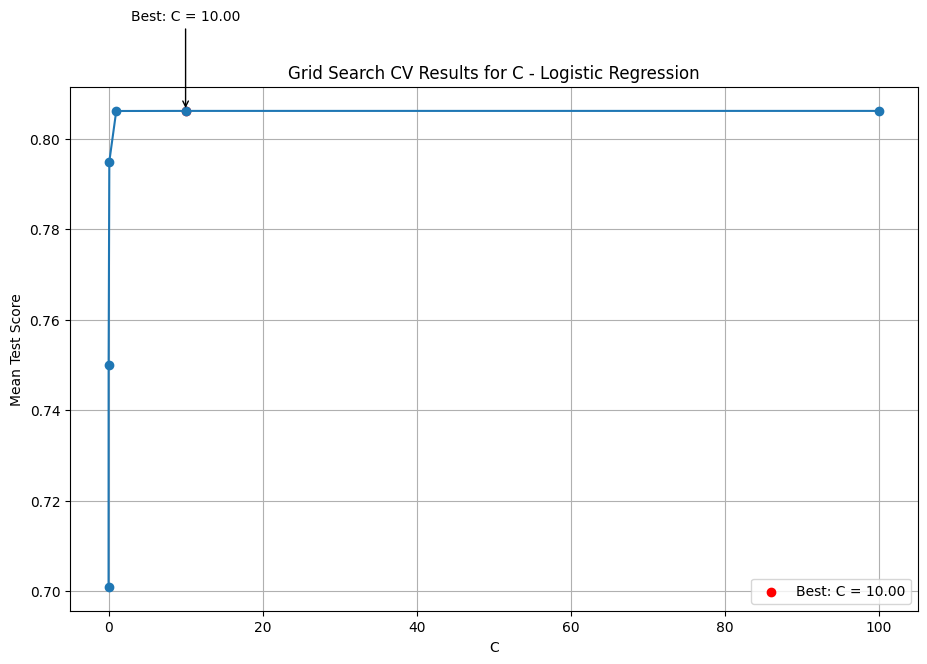

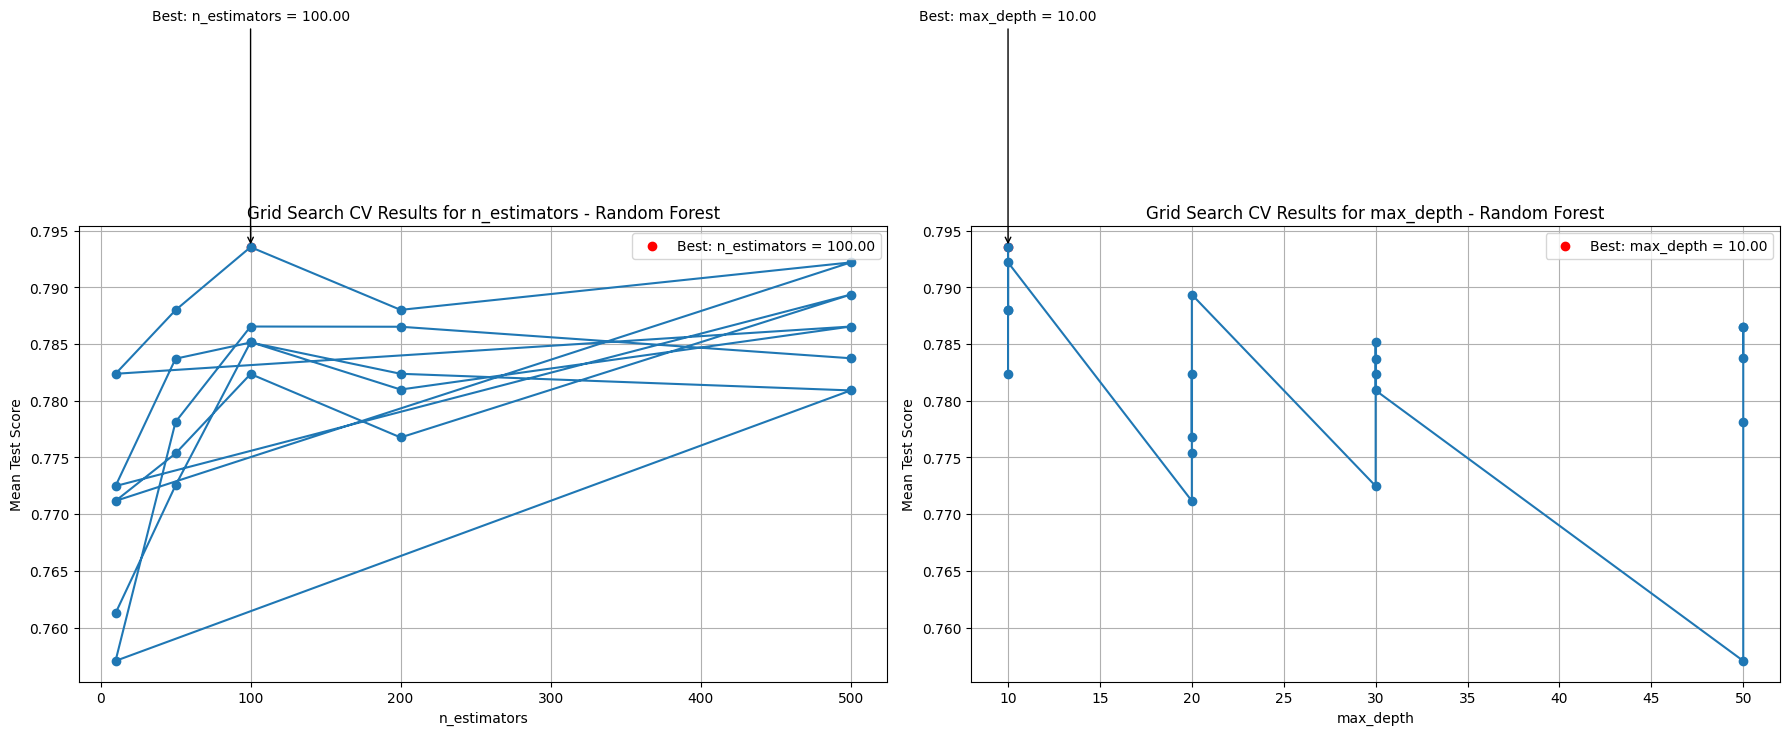

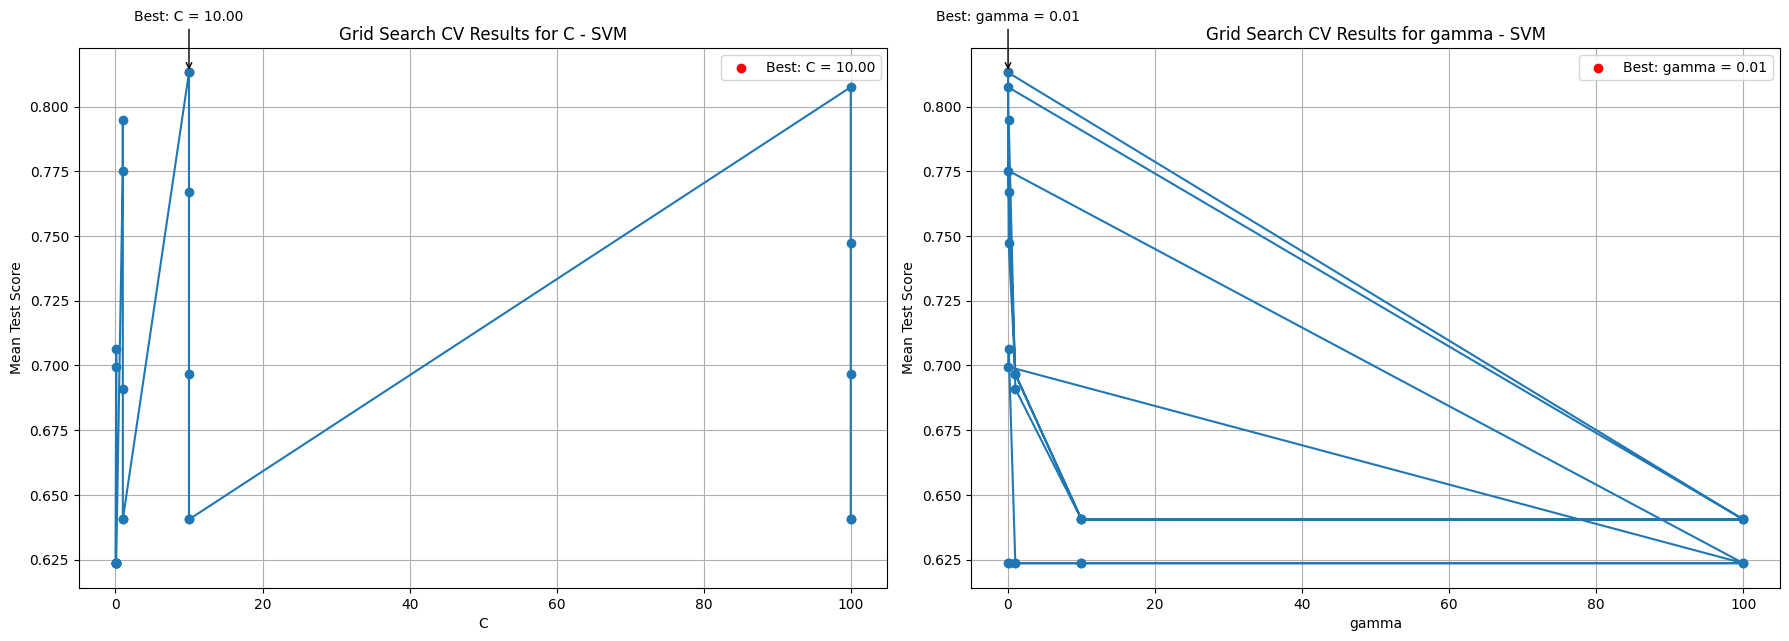

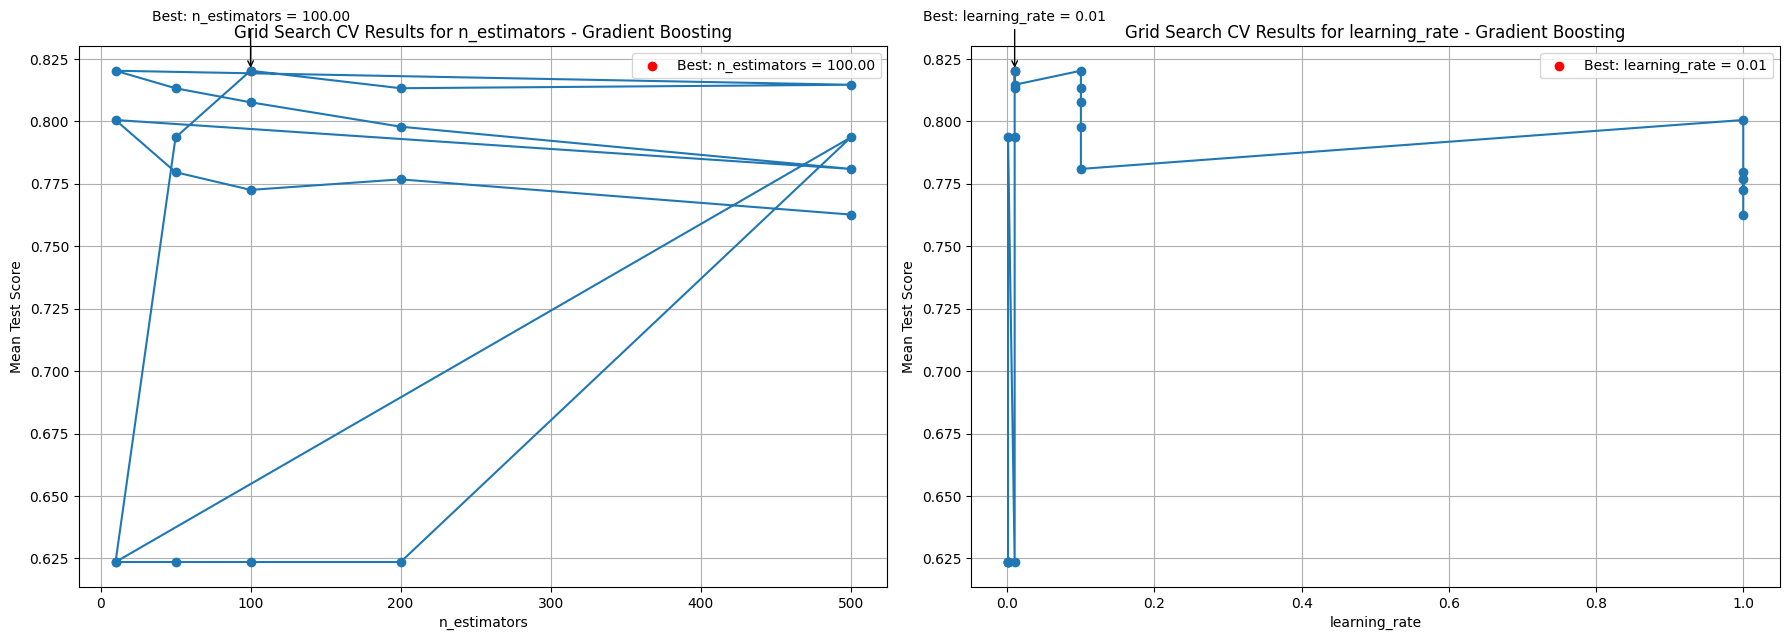

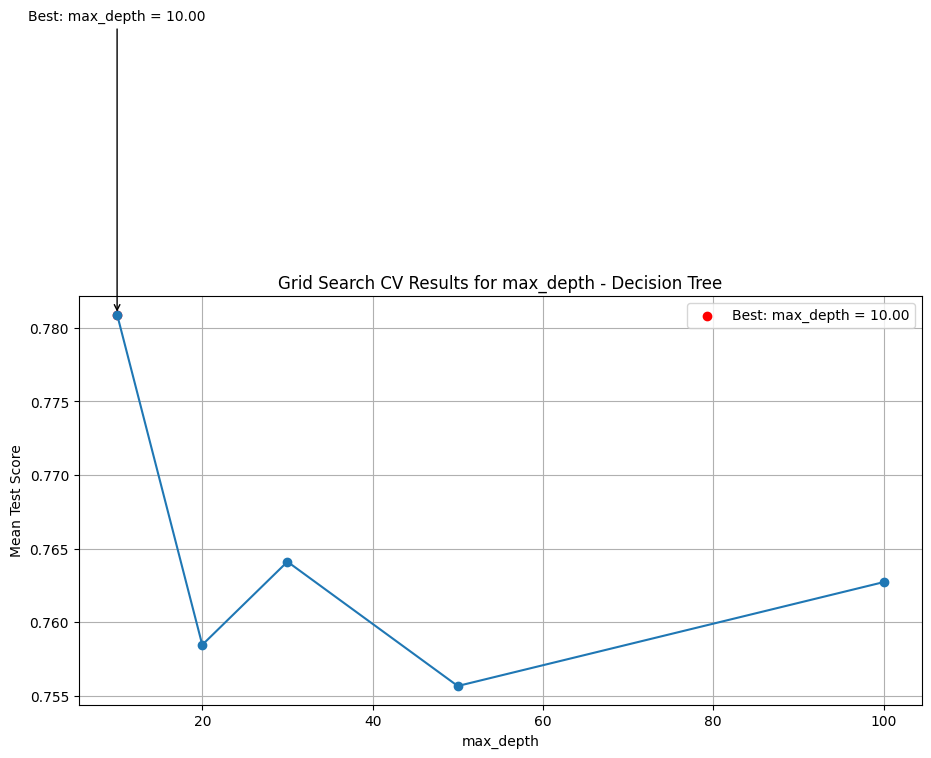

,Model,Best Parameters,Best Score (CV),Validation Score
0,Logistic Regression,{'C': 10},0.806123,0.804469
1,Random Forest,"{'max_depth': 10, 'n_estimators': 100}",0.793545,0.821229
2,SVM,"{'C': 10, 'gamma': 0.01}",0.813165,0.826816
3,Gradient Boosting,"{'learning_rate': 0.01, 'n_estimators': 100}",0.820227,0.798883
4,Decision Tree,{'max_depth': 10},0.780908,0.798883


In [ ]:
# Train and evaluate models
results, evaluation_df = train_and_evaluate_models(models, X_train, y_train, X_val, y_val, param_grids, scoring='accuracy', cv=10)
evaluation_df

We can see that SVM gives us the best Validation score, meaning SVM works best with new Data.

In [ ]:
best_model_row = evaluation_df.loc[evaluation_df['Validation Score'].idxmax()]
best_model_name = best_model_row['Model']
best_validation_score = best_model_row['Validation Score']

best_model = models[best_model_name]

print("Best Model: ", best_model_name)
print("Best Validation Score: {:.4f}" .format(best_validation_score))
best_model

Best Model:  SVM
Best Validation Score: 0.8268


SVC(C=10, gamma=0.01)

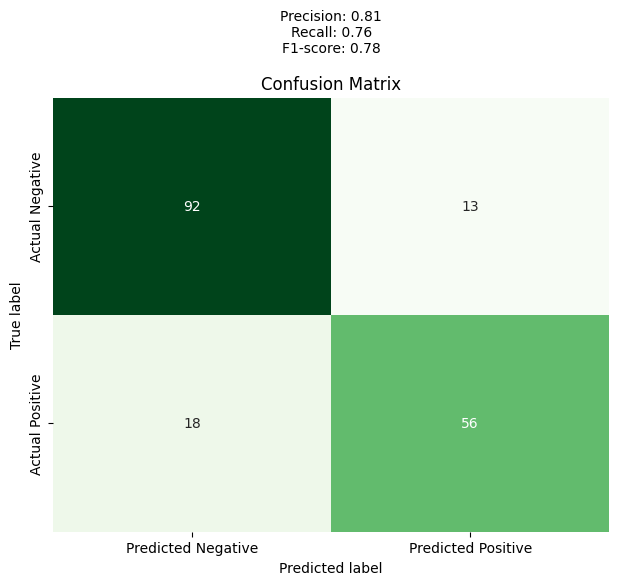

Train Accuracy: 0.8272
Validation Accuracy: 0.8268


(0.827247191011236,
 0.8268156424581006,
 0.8115942028985508,
 0.7567567567567568,
 0.7832167832167832)

In [ ]:
evaluate_best_model(best_model, X_train, y_train, X_val, y_val)

### Lasso and Ridge Regularization

In [ ]:
# Creating a Lasso Regularization model
lasso_model = Lasso(alpha=0.1)
# Creating a Ridge Regularization model
ridge_model = Ridge(alpha=0.1)

# Cross-validation to plot the cost function
alphas = np.logspace(-4, 4, 100)  # Range of alpha values for cross-validation
scores_lasso = []
scores_ridge = []

### 10-fold Cross Validation using initial Hyper Parameters

In order to tune Performance in every model, we'll have multiple values of the hyper paramaters and find the values that give us the best cross validation score, which in this case is accuracy scores:

In [ ]:
X_train.isna().sum()

Pclass            0
Sex               0
Age               0
Parch             0
Fare              0
Embarked          0
Words_Count       0
cabin_multiple    0
cabin_deck        0
FamilySize        0
IsAlone           0
Age*Class         0
dtype: int64

In [ ]:
for alpha in alphas:
    lasso_model.alpha = alpha
    cv_scores_lasso = cross_val_score(lasso_model, X_train, y_train, cv=10)  # 10-fold cross-validation
    scores_lasso.append(np.mean(cv_scores_lasso))

    ridge_model.alpha = alpha
    cv_scores_ridge = cross_val_score(ridge_model, X_train, y_train, cv=10)  # 10-fold cross-validation
    scores_ridge.append(np.mean(cv_scores_ridge))

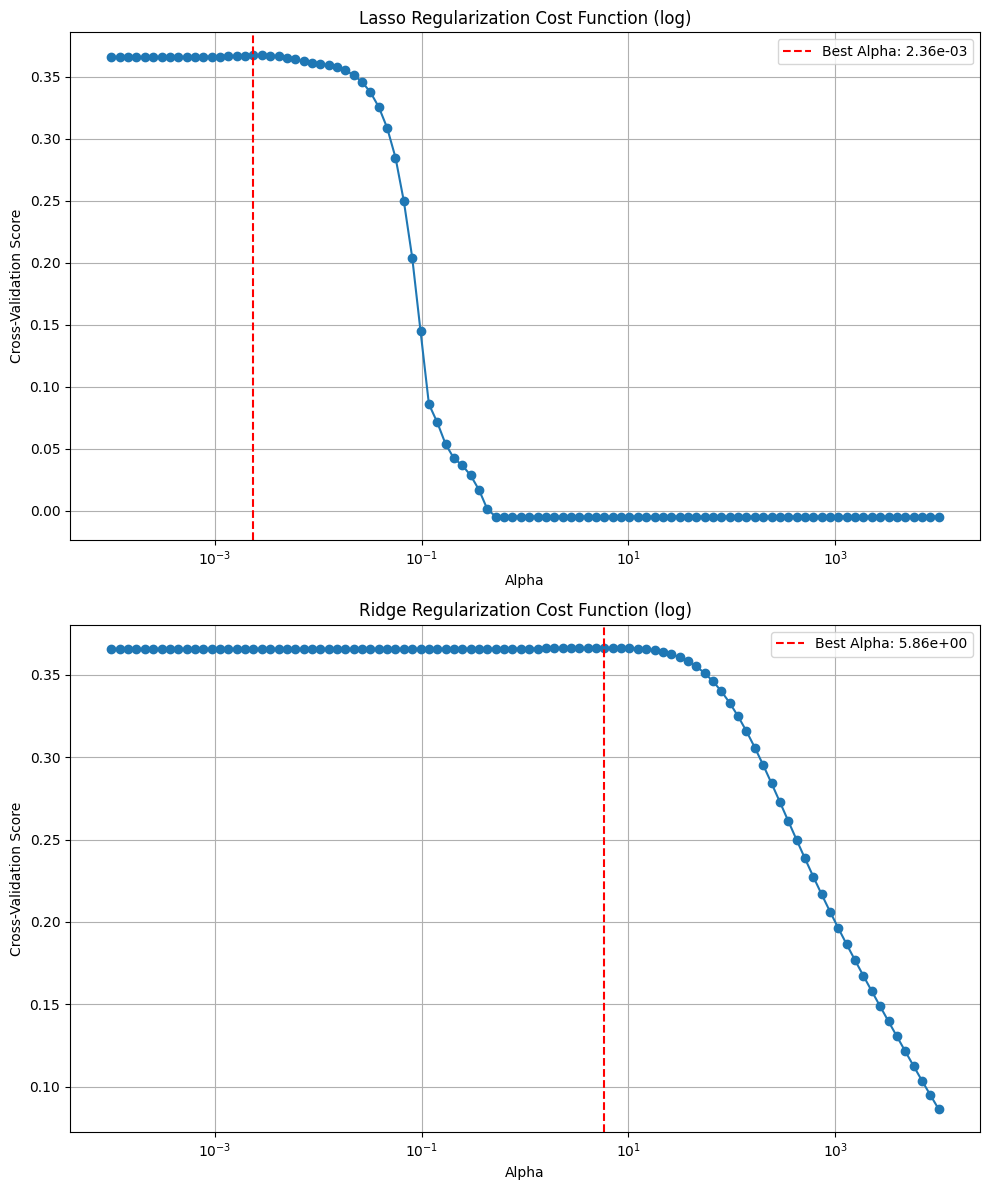

In [ ]:
# Finding the best alpha value
best_alpha_lasso = alphas[np.argmax(scores_lasso)]
best_alpha_ridge = alphas[np.argmax(scores_ridge)]

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Plotting the cost function for Lasso Regularization
axs[0].plot(alphas, scores_lasso, '-o')
axs[0].set_xlabel('Alpha')
axs[0].set_ylabel('Cross-Validation Score')
axs[0].set_title('Lasso Regularization Cost Function (log)')
axs[0].set_xscale('log')
axs[0].grid(True)

# Highlighting the best alpha value for Lasso Regularization
axs[0].axvline(x=best_alpha_lasso, color='r', linestyle='--', label='Best Alpha: {:.2e}'.format(best_alpha_lasso))
axs[0].legend()

# Plotting the cost function for another model (assuming you have another set of data)
axs[1].plot(alphas, scores_ridge, '-o')  # Replace scores_another_model with your actual scores
axs[1].set_xlabel('Alpha')
axs[1].set_ylabel('Cross-Validation Score')
axs[1].set_title('Ridge Regularization Cost Function (log)')
axs[1].set_xscale('log')
axs[1].grid(True)

# Highlighting the best alpha value for the another model
axs[1].axvline(x=best_alpha_ridge, color='r', linestyle='--', label='Best Alpha: {:.2e}'.format(best_alpha_ridge))
axs[1].legend()

# Adjust layout
plt.tight_layout()

plt.show()

After tuning, we fit the hyperparameters into the model and fit the trained data to this model:

In [ ]:
# Training the model with the best alpha
lasso_model.alpha = best_alpha_lasso
lasso_model.fit(X_train, y_train)

# Training the model with the best alpha
ridge_model.alpha = best_alpha_ridge
ridge_model.fit(X_train, y_train)

# Predictions on train and validation data
train_predictions_lasso = lasso_model.predict(X_train)
train_predictions_ridge = ridge_model.predict(X_train)
val_predictions_lasso = lasso_model.predict(X_val)
val_predictions_ridge = ridge_model.predict(X_val)

# Accuracy metrics
train_accuracy_lasso = accuracy_score(y_train, np.round(train_predictions_lasso))
train_accuracy_ridge = accuracy_score(y_train, np.round(train_predictions_ridge)) # Round predictions to 0 or 1 for binary classification
val_accuracy_lasso = accuracy_score(y_val, np.round(val_predictions_lasso))
val_accuracy_ridge = accuracy_score(y_val, np.round(val_predictions_ridge))

print("Train Accuracy: \nLasso - {:.4f}" .format(train_accuracy_lasso) ,"\nRidge - {:.4f} \n" .format(train_accuracy_ridge))
print("Validation Accuracy: \nLasso - {:.4f}" .format(val_accuracy_lasso) ,"\nRidge - {:.4f} " .format(val_accuracy_ridge))

Train Accuracy: 
Lasso - 0.7978 
Ridge - 0.8020 

Validation Accuracy: 
Lasso - 0.7989 
Ridge - 0.7933 


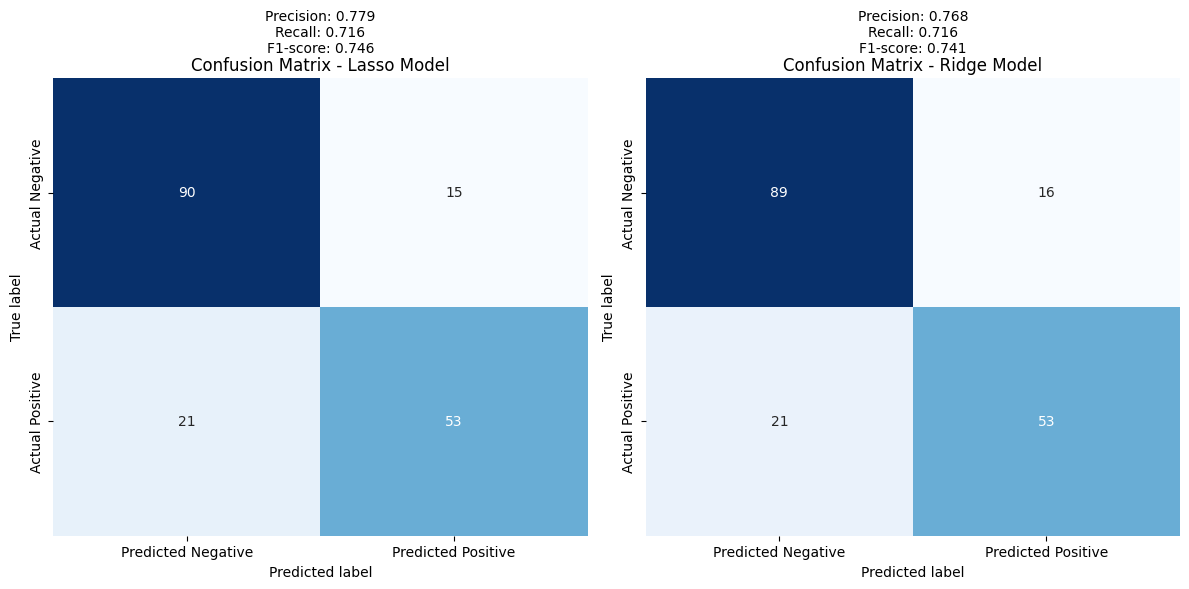

In [ ]:
# Confusion matrix for Lasso model
conf_matrix_lasso = confusion_matrix(y_val, np.round(val_predictions_lasso))

# Confusion matrix for Ridge model
conf_matrix_ridge = confusion_matrix(y_val, np.round(val_predictions_ridge))

# Calculate precision, recall, and F1-score for Lasso Model
precision_lasso = precision_score(y_val, np.round(val_predictions_lasso))
recall_lasso = recall_score(y_val, np.round(val_predictions_lasso))
f1_lasso = f1_score(y_val, np.round(val_predictions_lasso))

# Calculate precision, recall, and F1-score for Ridge Model
precision_ridge = precision_score(y_val, np.round(val_predictions_ridge))
recall_ridge = recall_score(y_val, np.round(val_predictions_ridge))
f1_ridge = f1_score(y_val, np.round(val_predictions_ridge))

# Plot confusion matrix with additional metrics for Lasso Model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_lasso, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title("Confusion Matrix - Lasso Model")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.text(0.5, 1.1, f"Precision: {precision_lasso:.3f}\nRecall: {recall_lasso:.3f}\nF1-score: {f1_lasso:.3f}",
         horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

# Plot confusion matrix with additional metrics for Ridge Model
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_ridge, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title("Confusion Matrix - Ridge Model")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.text(0.5, 1.1, f"Precision: {precision_ridge:.3f}\nRecall: {recall_ridge:.3f}\nF1-score: {f1_ridge:.3f}",
         horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

## Gradient Boosting

Tuning Boosting Hyperparameters using Grid search 10-fold Cross Validation:

In [ ]:
# Define hyperparameters grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Create a Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier(random_state=42)

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=gb_classifier, param_grid=param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Create a new Gradient Boosting Classifier with the best hyperparameters
best_gb_classifier = GradientBoostingClassifier(**best_params, random_state=42)
best_gb_classifier.fit(X_train, y_train)

# Plotting the cost function
results = grid_search.cv_results_
scores = results['mean_test_score']
params = results['params']


#### Results and Fitting model:

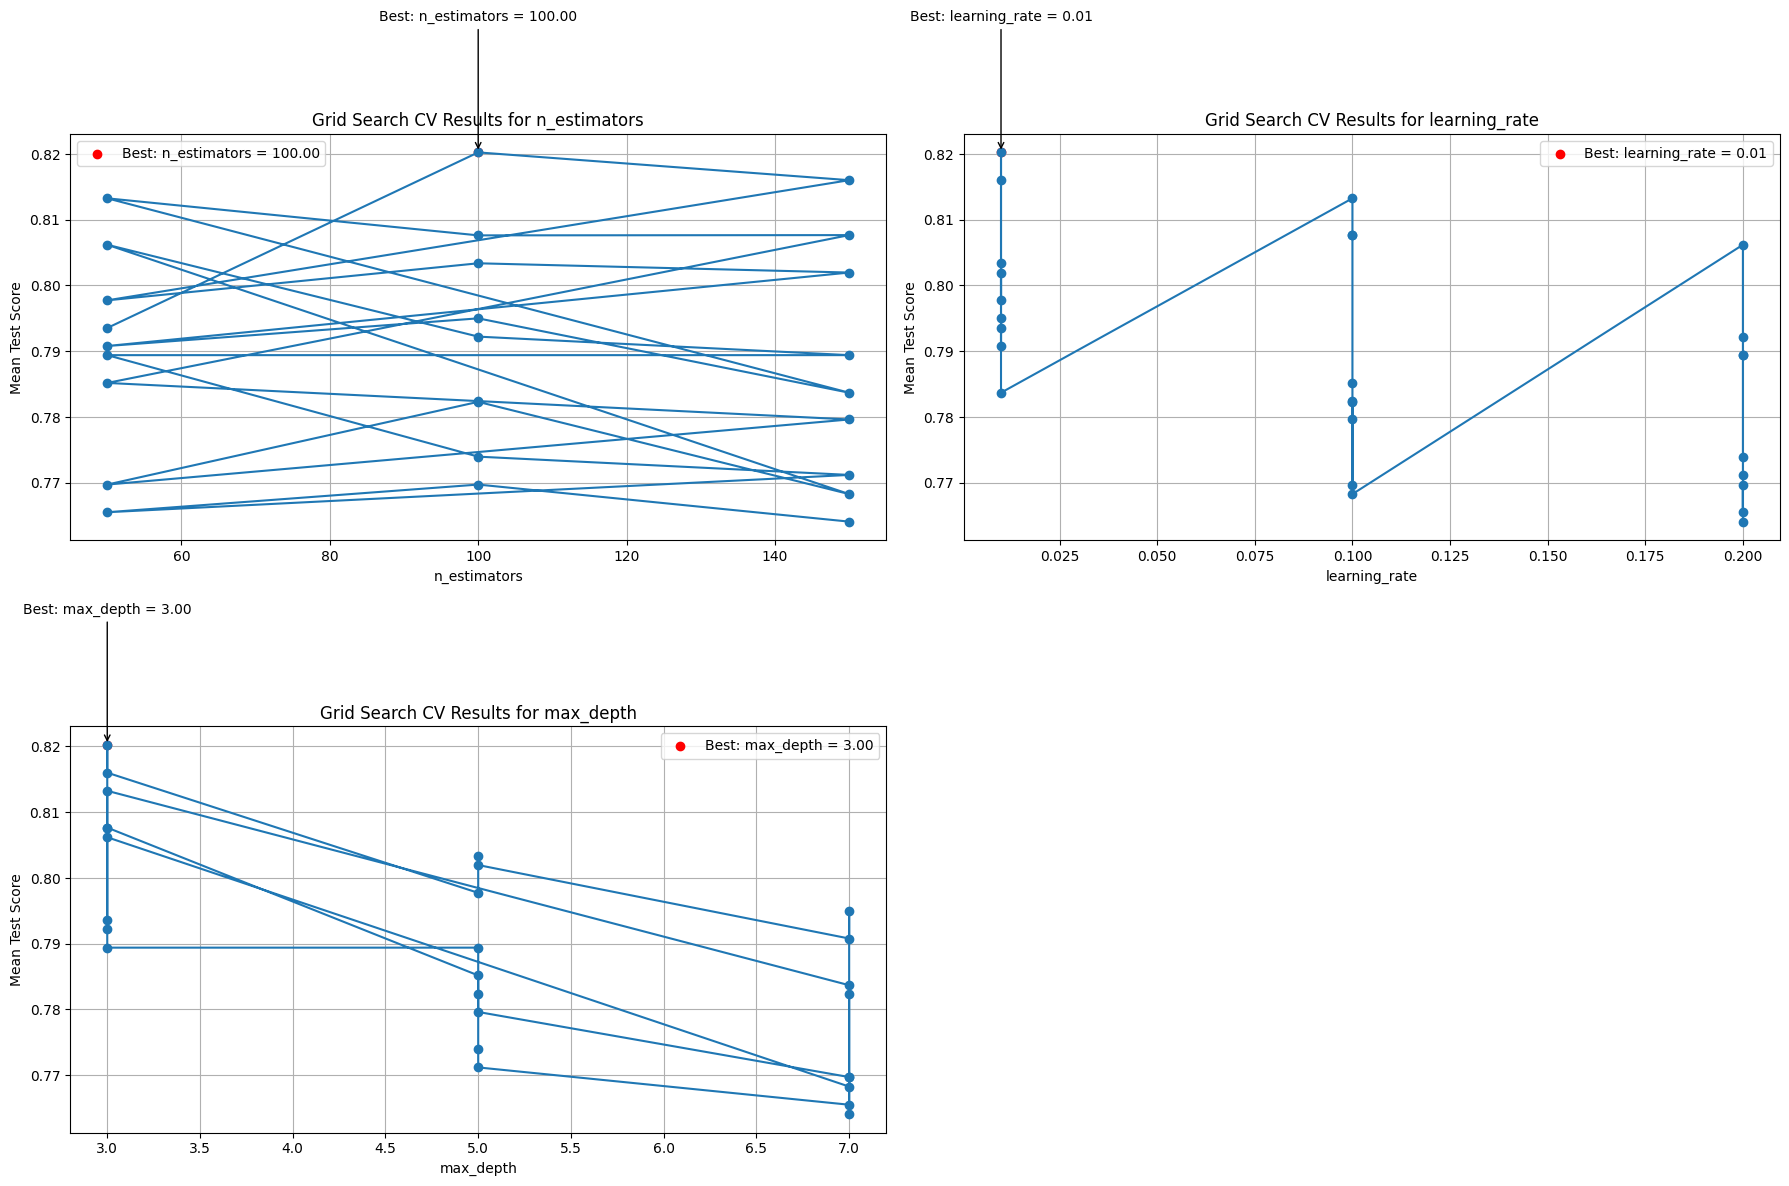

Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Train Accuracy: 0.8258
Validation Accuracy: 0.7989


In [ ]:
plt.figure(figsize=(18, 12))

for i, param_name in enumerate(param_grid.keys()):
    plt.subplot(2, 2, i + 1)
    param_values = [param[param_name] for param in params]
    plt.plot(param_values, scores, marker='o')
    plt.xlabel(param_name)
    plt.ylabel('Mean Test Score')
    plt.title('Grid Search CV Results for {}'.format(param_name))
    plt.grid(True)

  # Marking the best parameter value
    best_value = best_params[param_name]
    best_score = grid_search.best_score_
    plt.scatter(best_value, best_score, color='red', label='Best: {} = {:.2f}'.format(param_name, best_value))
    plt.annotate('Best: {} = {:.2f}'.format(param_name, best_value), xy=(best_value, best_score), xytext=(best_value, best_score + 0.02),
                 arrowprops=dict(facecolor='black', arrowstyle='->'), horizontalalignment='center')
    plt.legend()

plt.tight_layout()
plt.show()

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

# Predictions on validation data
train_predictions = best_gb_classifier.predict(X_train)

# Predictions on validation data
val_predictions = best_gb_classifier.predict(X_val)

# Accuracy metrics
train_accuracy = accuracy_score(y_train, np.round(train_predictions))
val_accuracy = accuracy_score(y_val, np.round(val_predictions))

print("Train Accuracy: {:.4f}" .format(train_accuracy))
print("Validation Accuracy: {:.4f}" .format(val_accuracy))

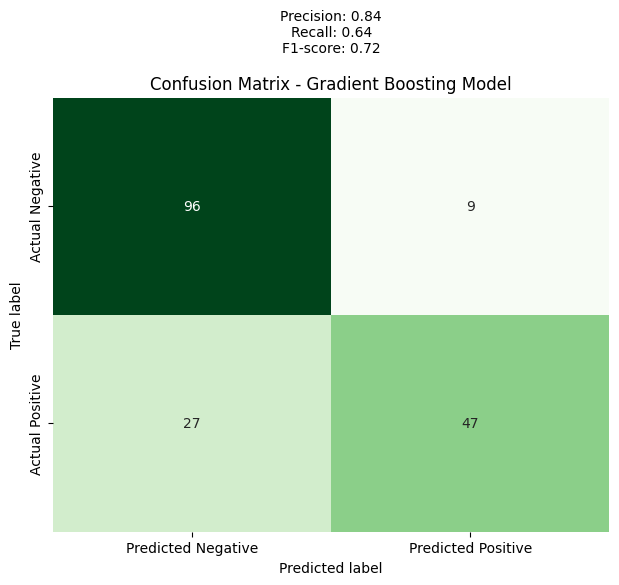

In [ ]:
# Confusion matrix for Gradient Boosting Model
conf_matrix = confusion_matrix(y_val, np.round(val_predictions))

# Calculate precision, recall, and F1-score for Gradient Boosting Model
precision_gb = precision_score(y_val, np.round(val_predictions))
recall_gb = recall_score(y_val, np.round(val_predictions))
f1_gb = f1_score(y_val, np.round(val_predictions))

# Plot confusion matrix with additional metrics for Gradient Boosting Model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title("Confusion Matrix - Gradient Boosting Model")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.text(0.5, 1.15, f"Precision: {precision_gb:.2f}\nRecall: {recall_gb:.2f}\nF1-score: {f1_gb:.2f}",
         horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.tight_layout()
plt.show()

## SVM

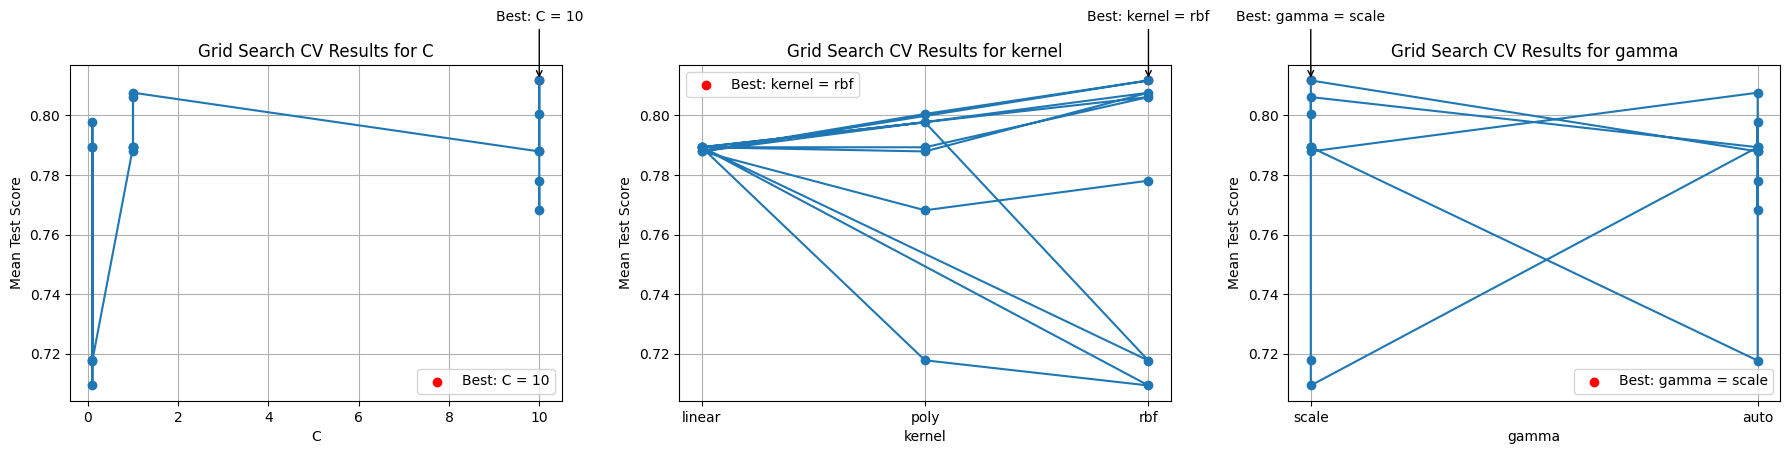

Best Hyperparameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Train Accuracy: 0.8371
Validation Accuracy: 0.8268


In [ ]:
# Define hyperparameters grid for SVM
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Create a Support Vector Classifier (SVC)
svm_classifier = SVC(random_state=42)

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Create a new Support Vector Classifier with the best hyperparameters
best_svm_classifier = SVC(**best_params, random_state=42)
best_svm_classifier.fit(X_train, y_train)

# Plotting the results
results = grid_search.cv_results_
scores = results['mean_test_score']
params = results['params']

plt.figure(figsize=(18, 12))

for i, param_name in enumerate(param_grid.keys()):
    plt.subplot(3, 3, i + 1)
    param_values = [param[param_name] for param in params]
    plt.plot(param_values, scores, marker='o')
    plt.xlabel(param_name)
    plt.ylabel('Mean Test Score')
    plt.title('Grid Search CV Results for {}'.format(param_name))
    plt.grid(True)

    # Marking the best parameter value
    best_value = best_params[param_name]
    best_score = grid_search.best_score_
    plt.scatter(best_value, best_score, color='red', label='Best: {} = {}'.format(param_name, best_value))
    plt.annotate('Best: {} = {}'.format(param_name, best_value), xy=(best_value, best_score), xytext=(best_value, best_score + 0.02),
                 arrowprops=dict(facecolor='black', arrowstyle='->'), horizontalalignment='center')
    plt.legend()

plt.tight_layout()
plt.show()

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

# Predictions on training data
train_predictions = best_svm_classifier.predict(X_train)

# Predictions on validation data
val_predictions = best_svm_classifier.predict(X_val)

# Accuracy metrics
train_accuracy = accuracy_score(y_train, train_predictions)
val_accuracy = accuracy_score(y_val, val_predictions)

print("Train Accuracy: {:.4f}" .format(train_accuracy))
print("Validation Accuracy: {:.4f}" .format(val_accuracy))

*we added more variety of values in the parameters, but it took longer with no impact to the accuracy, so we stayed with these values.

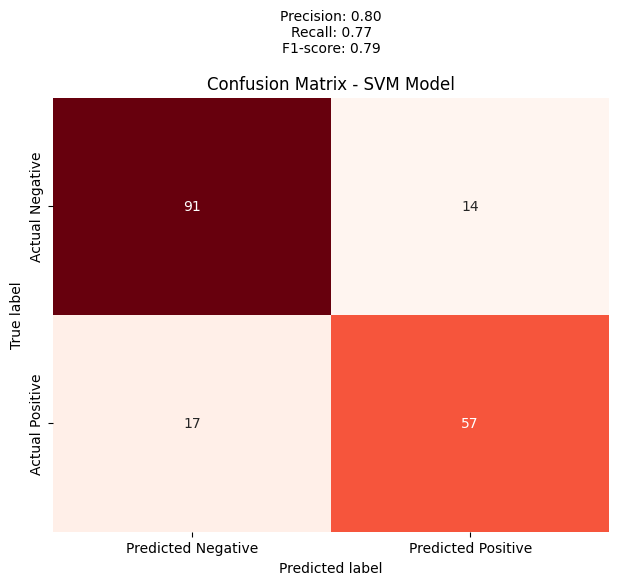

In [ ]:
# Confusion matrix for SVM Model
conf_matrix = confusion_matrix(y_val, np.round(val_predictions))

# Calculate precision, recall, and F1-score for SVM Model
precision_svm = precision_score(y_val, np.round(val_predictions))
recall_svm = recall_score(y_val, np.round(val_predictions))
f1_svm = f1_score(y_val, np.round(val_predictions))

# Plot confusion matrix with additional metrics for SVM Model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds", cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title("Confusion Matrix - SVM Model")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.text(0.5, 1.15, f"Precision: {precision_svm:.2f}\nRecall: {recall_svm:.2f}\nF1-score: {f1_svm:.2f}",
         horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.tight_layout()
plt.show()

## Test input data for submission

In [ ]:
passenger_df_test = passenger_df[passenger_df.Survived == -1].drop("Survived", axis=1)
passenger_df_test.head(10)

,Pclass,Sex,Age,Parch,Fare,Embarked,Words_Count,cabin_multiple,cabin_deck,FamilySize,IsAlone,Age*Class
PassengerId,,,,,,,,,,,,
892,3,1,4.0,0,1,2,3,0,0,1,1,12.0
893,3,0,5.0,0,1,0,5,0,0,2,0,15.0
894,2,1,5.0,0,1,2,4,0,0,1,1,10.0
895,3,1,2.0,0,1,0,3,0,0,1,1,6.0
896,3,0,1.0,1,2,0,6,0,0,3,0,3.0
897,3,1,0.0,0,1,0,4,0,0,1,1,0.0
898,3,0,3.0,0,1,2,3,0,0,1,1,9.0
899,2,1,2.0,1,4,0,4,0,0,3,0,4.0
900,3,0,1.0,0,1,1,6,0,0,1,1,3.0


In [ ]:
predictions = best_model.predict(passenger_df_test)
#predictions = best_svm_classifier.predict(passenger_df_test)
#predictions = best_gb_classifier.predict(passenger_df_test)
#predictions = lasso_model.predict(passenger_df_test)
#predictions = ridge_model.predict(passenger_df_test)
predictions = predictions.astype(int)

## Convert predictions into binary output
#binary_predictions = (predictions >= 0.5).astype(int)

output = pd.DataFrame({'PassengerId': passenger_df_test.index, 'Survived': predictions})
#output = pd.DataFrame({'PassengerId': passenger_df_test.index, 'Survived': binary_predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [ ]:
output

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
